This notebook contains BDT variables distribution for different types of signals added up together. Triggered events only.

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor
import uproot
from awkward import JaggedArray

import numpy as np
np.seterr(divide='ignore', invalid='ignore', over='ignore')
import matplotlib
import matplotlib.pyplot as plt
from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged
from FireHydrant.Tools.trigger import Triggers
from FireHydrant.Tools.metfilter import MetFilters
from FireHydrant.Tools.correction import get_pu_weights_function

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json

dataset4mu_ = json.load(open('../Samples/signal_4mu.json'))
dataset2mu2e_ = json.load(open('../Samples/signal_2mu2e.json'))

## grouped together
dataset=dict(
    sig4mu={'files': [], 'treename': 'ffNtuplizer/ffNtuple'},
    sig2mu2e={'files': [], 'treename': 'ffNtuplizer/ffNtuple'},
)

for k in dataset4mu_: dataset['sig4mu']['files'].extend(dataset4mu_[k])
for k in dataset2mu2e_: dataset['sig2mu2e']['files'].extend(dataset2mu2e_[k])
    
## keep them splited
scale4mu_ = json.load(open('../Samples/signal_4mu_scale.json'))
scale2mu2e_ = json.load(open('../Samples/signal_2mu2e_scale.json'))
lumi = 60.432
scales={}
for k in scale4mu_:
    scales[f'4mu/{k}'] = lumi * scale4mu_[k]
for k in scale2mu2e_:
    scales[f'2mu2e/{k}'] = lumi * scale2mu2e_[k]
datasetsplit = {}
for k in dataset4mu_:
    datasetsplit[f'4mu/{k}'] = dict(files=dataset4mu_[k], treename='ffNtuplizer/ffNtuple')
for k in dataset2mu2e_:
    datasetsplit[f'2mu2e/{k}'] = dict(files=dataset2mu2e_[k], treename='ffNtuplizer/ffNtuple')

### Let's plot leptonJets' pT again..

In [3]:
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "signal")
        pt_axis = hist.Bin("pt", r"$p_T$ [GeV]", 50, 0, 800)
        multi_axis = hist.Bin("multi", "#leptonJets/event", 10, 0, 10)
        match_axis = hist.Cat('match', 'matched')
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("A.U.", dataset_axis, pt_axis, match_axis),
            'multi': hist.Hist("A.U.", dataset_axis, multi_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid']
        )
        darkphotons = genparticles[genparticles.pid==32]
        matchmask = leptonjets.match(darkphotons, deltaRCut=0.3)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        
        leptonjets_t = leptonjets[matchmask][metfiltermask&triggermask]
        leptonjets_f = leptonjets[~matchmask][metfiltermask&triggermask]

        output['pt'].fill(dataset=dataset, match='matched', pt=leptonjets_t.pt.flatten())
        output['pt'].fill(dataset=dataset, match='unmatched', pt=leptonjets_f.pt.flatten())
        
        output['multi'].fill(dataset=dataset, multi=leptonjets[metfiltermask&triggermask].counts)
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [5]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing:   0%|          | 0/300 [00:00<?, ?items/s]/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7

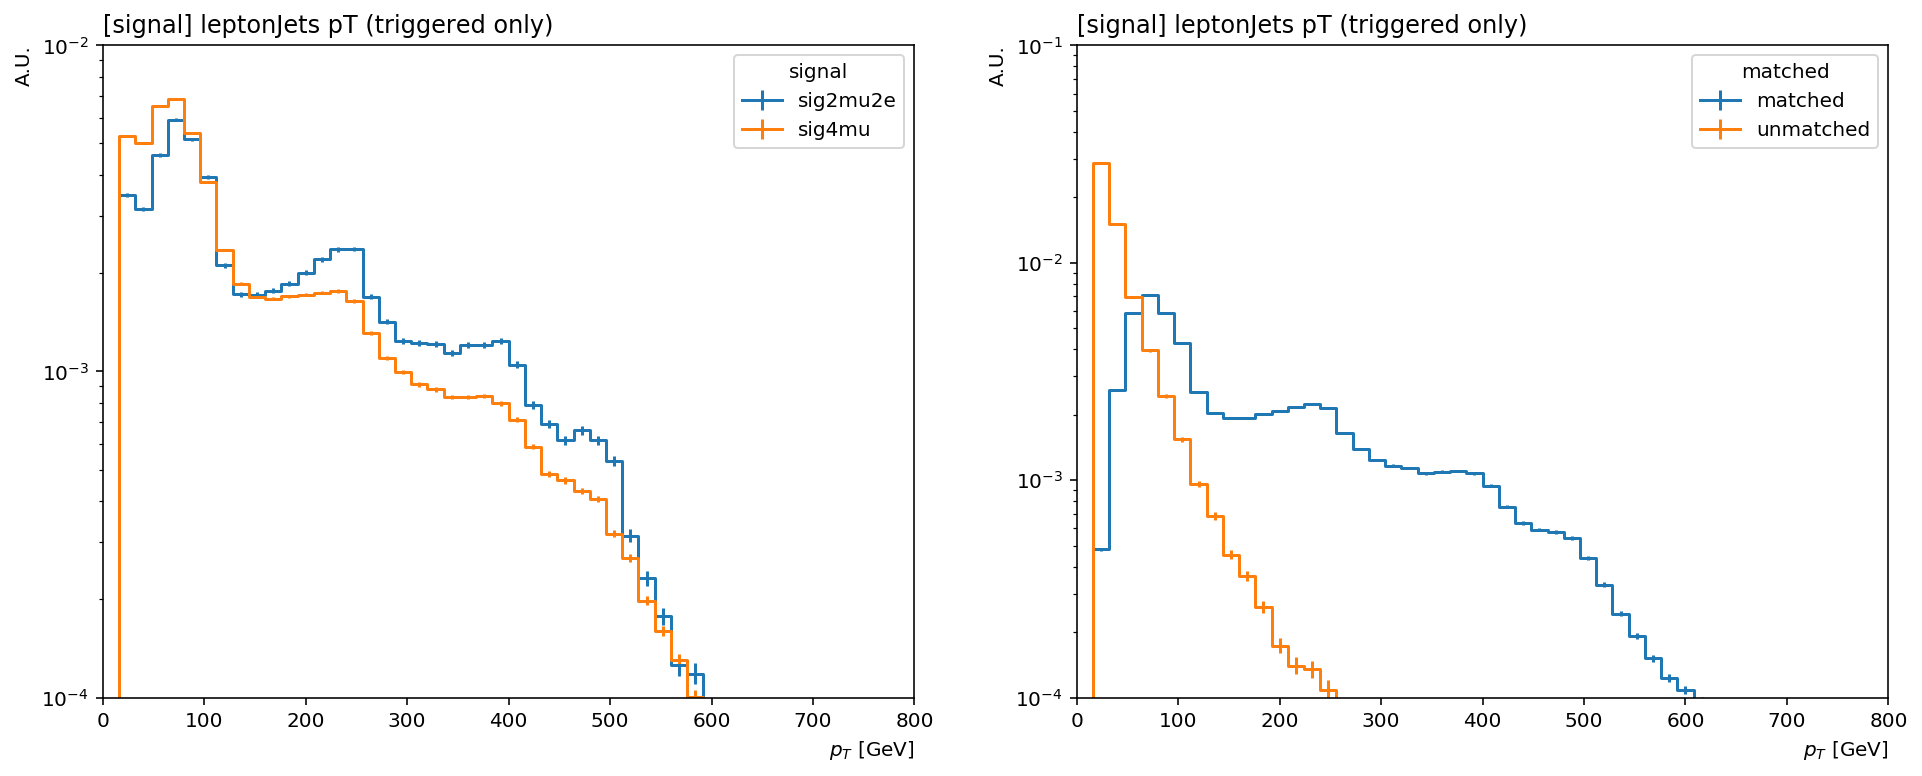

In [6]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['pt'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['pt'].project('dataset'), overlay='match', ax=axes[1], density=True)
axes[0].set_ylim([1e-4, 1e-2])
axes[1].set_ylim([1e-4, 1e-1])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[signal] leptonJets pT (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

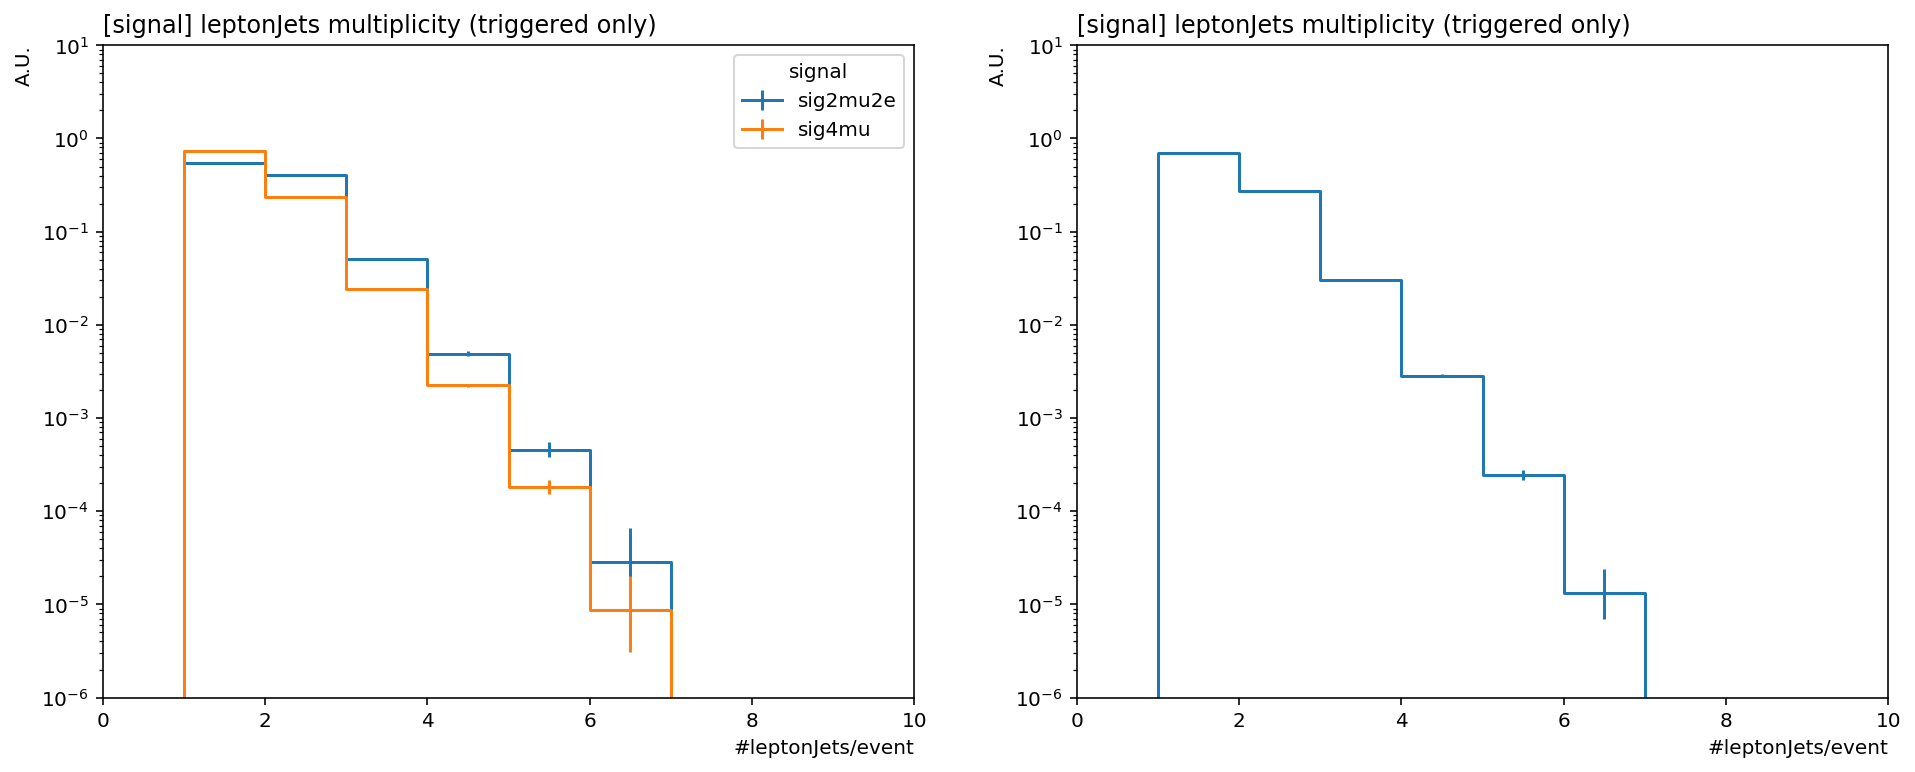

In [7]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['multi'], overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['multi'].project('dataset'), ax=axes[1], density=True)
axes[0].set_ylim([1e-6, 1e1])
axes[1].set_ylim([1e-6, 1e1])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[signal] leptonJets multiplicity (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

## Variables as input for BDT
- leptonJet pT, eta
- neutral energy fraction
- maxd0, mind0
- tkiso, pfiso
- spreadpt, spreaddr
- lambda, epsilon
- ecf 1,2,3

and
- BDT score

In [47]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'signal datasets')
        match_axis   = hist.Cat('match', 'matched')
        pt_axis       = hist.Bin("pt", "pT [GeV]", 50, 0, 800)
        eta_axis      = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        nef_axis      = hist.Bin("nef", "neutral energy fraction", 50, 0, 1)
        maxd0_axis    = hist.Bin("maxd0", 'track max |d0|', 50, 0, 0.5)
        mind0_axis    = hist.Bin("mind0", 'track min |d0|', 50, 0, 0.5)
        tkiso_axis    = hist.Bin('tkiso', 'track isolation', 50, 0, 1)
        pfiso_axis    = hist.Bin("pfiso", "PFCands isolation", 50, 0, 1)
        spreadpt_axis = hist.Bin("spreadpt", "spreadpt", 50, 0, 1)
        spreaddr_axis = hist.Bin("spreaddr", "spreaddr", 50, 0, 0.1)
        lambda_axis   = hist.Bin('lamb', 'jet sub - lambda', 50, -8, 0)
        epsilon_axis  = hist.Bin('epsi', 'jet sub - epsilon', 50, 0, 0.25)
        ecfe1_axis    = hist.Bin('ecfe1', 'energy correlation function - e1', 50, 0, 750)
        ecfe2_axis    = hist.Bin('ecfe2', 'energy correlation function - e2', 50, 0, 2000)
        ecfe3_axis    = hist.Bin('ecfe3', 'energy correlation function - e3', 50, 0, 1000)
        mva_axis      = hist.Bin('mva', 'BDT value', 50, -10, 10)
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("#counts/16GeV", dataset_axis, pt_axis, match_axis),
            "eta": hist.Hist("#counts/0.096", dataset_axis, eta_axis, match_axis),
            "nef": hist.Hist("#counts/0.02", dataset_axis, nef_axis, match_axis),
            "maxd0": hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis, match_axis),
            "mind0": hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis, match_axis),
            "tkiso": hist.Hist("#counts/0.02", dataset_axis, tkiso_axis, match_axis),
            "pfiso": hist.Hist("#counts/0.02", dataset_axis, pfiso_axis, match_axis),
            "spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis, match_axis),
            "spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis, match_axis),
            "lamb": hist.Hist("#counts/0.16", dataset_axis, lambda_axis, match_axis),
            "epsi": hist.Hist("#counts/0.005", dataset_axis, epsilon_axis, match_axis),
            "ecfe1": hist.Hist("#counts/25", dataset_axis, ecfe1_axis, match_axis),
            "ecfe2": hist.Hist("#counts/40", dataset_axis, ecfe2_axis, match_axis),
            "ecfe3": hist.Hist("#counts/20", dataset_axis, ecfe3_axis, match_axis),
            "mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis, match_axis),
        })

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        maxd0_ = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0).max()
        mind0_ = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0).min()
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            nef=(df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT'],
            maxd0=maxd0_.content,
            mind0=mind0_.content,
            tkiso=df['pfjet_tkIsolation05'],
            pfiso=df['pfjet_pfIsolation05'],
            spreadpt=df['pfjet_ptDistribution'],
            spreaddr=df['pfjet_dRSpread'],
            lamb=df['pfjet_subjet_lambda'],
            epsi=df['pfjet_subjet_epsilon'],
            ecf1=df['pfjet_subjet_ecf1'],
            ecf2=df['pfjet_subjet_ecf2'],
            ecf3=df['pfjet_subjet_ecf3'],
            mva=df['pfjet_mva'],
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid']
        )
        darkphotons = genparticles[genparticles.pid==32]
        matchmask = leptonjets.match(darkphotons, deltaRCut=0.3)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        
        leptonjets_t = leptonjets[matchmask][metfiltermask&triggermask]
        leptonjets_f = leptonjets[~matchmask][metfiltermask&triggermask]

        
        output['pt']      .fill(dataset=dataset, match='matched', pt=leptonjets_t.pt.flatten())
        output['eta']     .fill(dataset=dataset, match='matched', eta=leptonjets_t.eta.flatten())
        output['nef']     .fill(dataset=dataset, match='matched', nef=leptonjets_t.nef.flatten())
        output['maxd0']   .fill(dataset=dataset, match='matched', maxd0=leptonjets_t.maxd0.flatten())
        output['mind0']   .fill(dataset=dataset, match='matched', mind0=leptonjets_t.mind0.flatten())
        output['tkiso']   .fill(dataset=dataset, match='matched', tkiso=leptonjets_t.tkiso.flatten())
        output['pfiso']   .fill(dataset=dataset, match='matched', pfiso=leptonjets_t.pfiso.flatten())
        output['spreadpt'].fill(dataset=dataset, match='matched', spreadpt=leptonjets_t.spreadpt.flatten())
        output['spreaddr'].fill(dataset=dataset, match='matched', spreaddr=leptonjets_t.spreaddr.flatten())
        output['lamb']    .fill(dataset=dataset, match='matched', lamb=leptonjets_t.lamb.flatten())
        output['epsi']    .fill(dataset=dataset, match='matched', epsi=leptonjets_t.epsi.flatten())
        output['ecfe1']   .fill(dataset=dataset, match='matched', ecfe1=leptonjets_t.ecf1.flatten())
        output['ecfe2']   .fill(dataset=dataset, match='matched', ecfe2=leptonjets_t.ecf2.flatten())
        output['ecfe3']   .fill(dataset=dataset, match='matched', ecfe3=leptonjets_t.ecf3.flatten())
        output['mva']     .fill(dataset=dataset, match='matched', mva=leptonjets_t.mva.flatten())
        
        output['pt']      .fill(dataset=dataset, match='unmatched', pt=leptonjets_f.pt.flatten())
        output['eta']     .fill(dataset=dataset, match='unmatched', eta=leptonjets_f.eta.flatten())
        output['nef']     .fill(dataset=dataset, match='unmatched', nef=leptonjets_f.nef.flatten())
        output['maxd0']   .fill(dataset=dataset, match='unmatched', maxd0=leptonjets_f.maxd0.flatten())
        output['mind0']   .fill(dataset=dataset, match='unmatched', mind0=leptonjets_f.mind0.flatten())
        output['tkiso']   .fill(dataset=dataset, match='unmatched', tkiso=leptonjets_f.tkiso.flatten())
        output['pfiso']   .fill(dataset=dataset, match='unmatched', pfiso=leptonjets_f.pfiso.flatten())
        output['spreadpt'].fill(dataset=dataset, match='unmatched', spreadpt=leptonjets_f.spreadpt.flatten())
        output['spreaddr'].fill(dataset=dataset, match='unmatched', spreaddr=leptonjets_f.spreaddr.flatten())
        output['lamb']    .fill(dataset=dataset, match='unmatched', lamb=leptonjets_f.lamb.flatten())
        output['epsi']    .fill(dataset=dataset, match='unmatched', epsi=leptonjets_f.epsi.flatten())
        output['ecfe1']   .fill(dataset=dataset, match='unmatched', ecfe1=leptonjets_f.ecf1.flatten())
        output['ecfe2']   .fill(dataset=dataset, match='unmatched', ecfe2=leptonjets_f.ecf2.flatten())
        output['ecfe3']   .fill(dataset=dataset, match='unmatched', ecfe3=leptonjets_f.ecf3.flatten())
        output['mva']     .fill(dataset=dataset, match='unmatched', mva=leptonjets_f.mva.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [48]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing:   0%|          | 0/300 [00:00<?, ?items/s]/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7

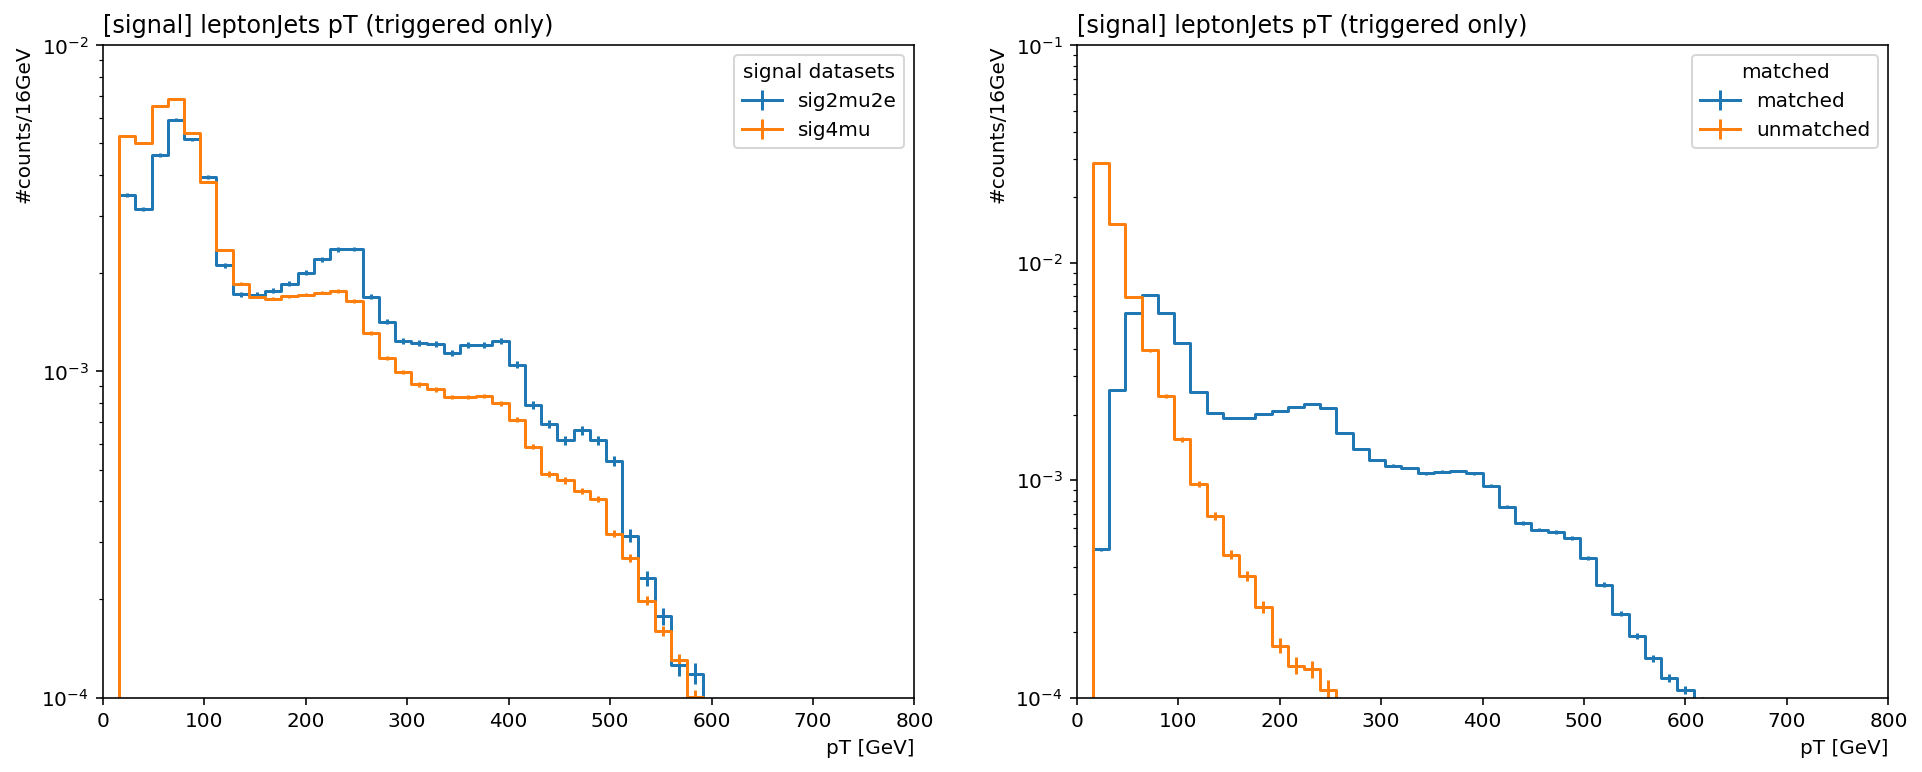

In [10]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['pt'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['pt'].project('dataset'), overlay='match', ax=axes[1], density=True)
axes[0].set_ylim([1e-4, 1e-2])
axes[1].set_ylim([1e-4, 1e-1])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[signal] leptonJets pT (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

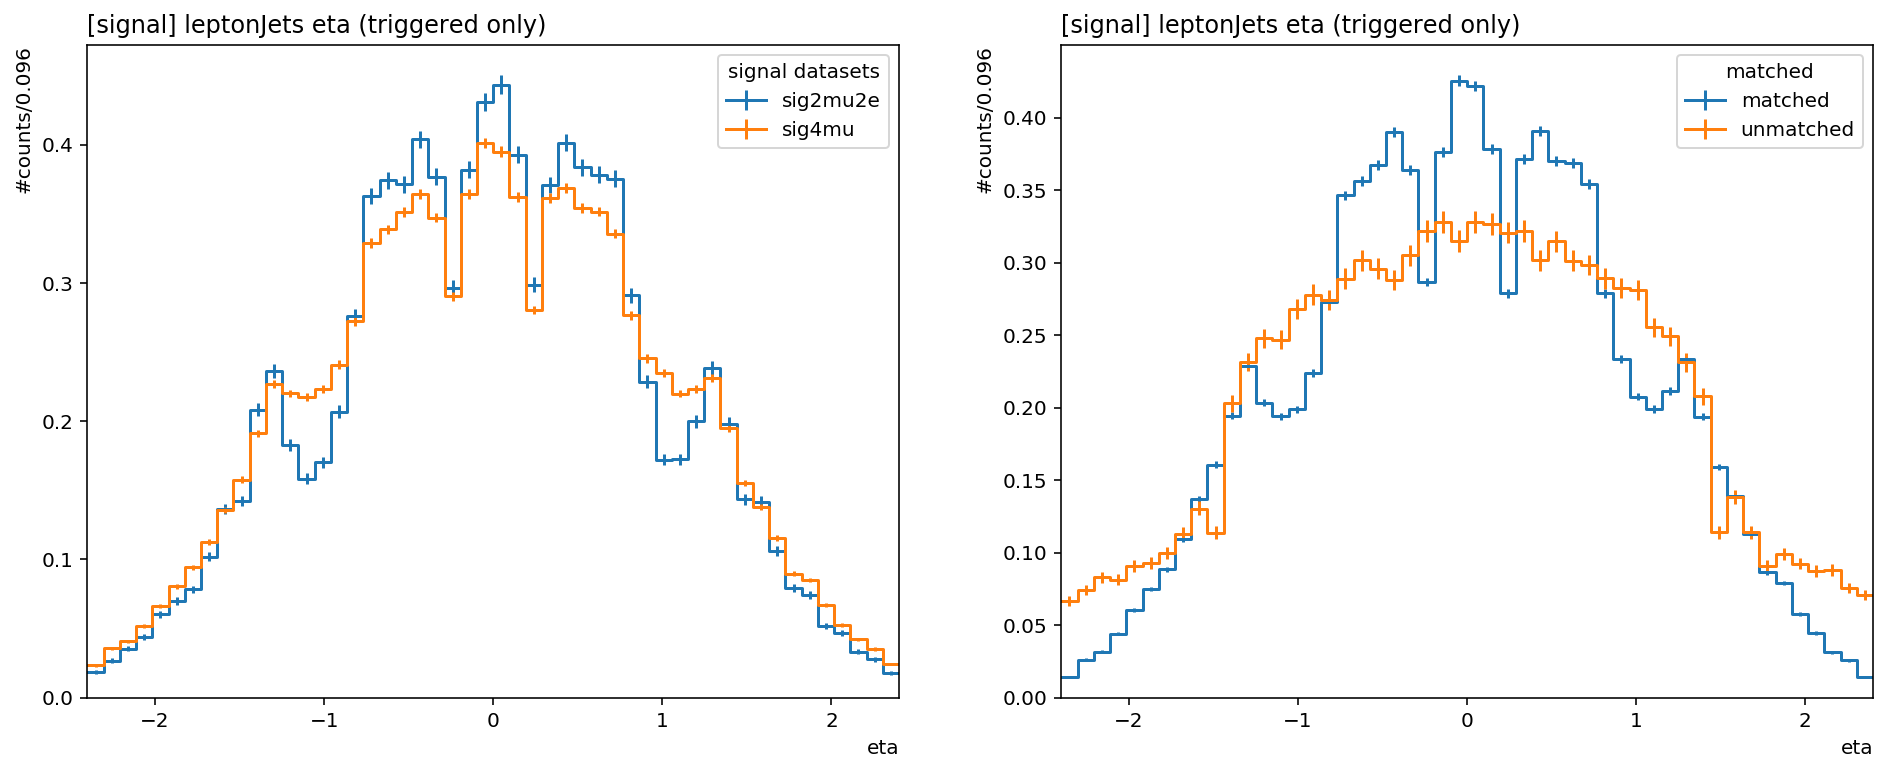

In [11]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['eta'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['eta'].project('dataset'), overlay='match', ax=axes[1], density=True)


for ax in axes:
    ax.set_title('[signal] leptonJets eta (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

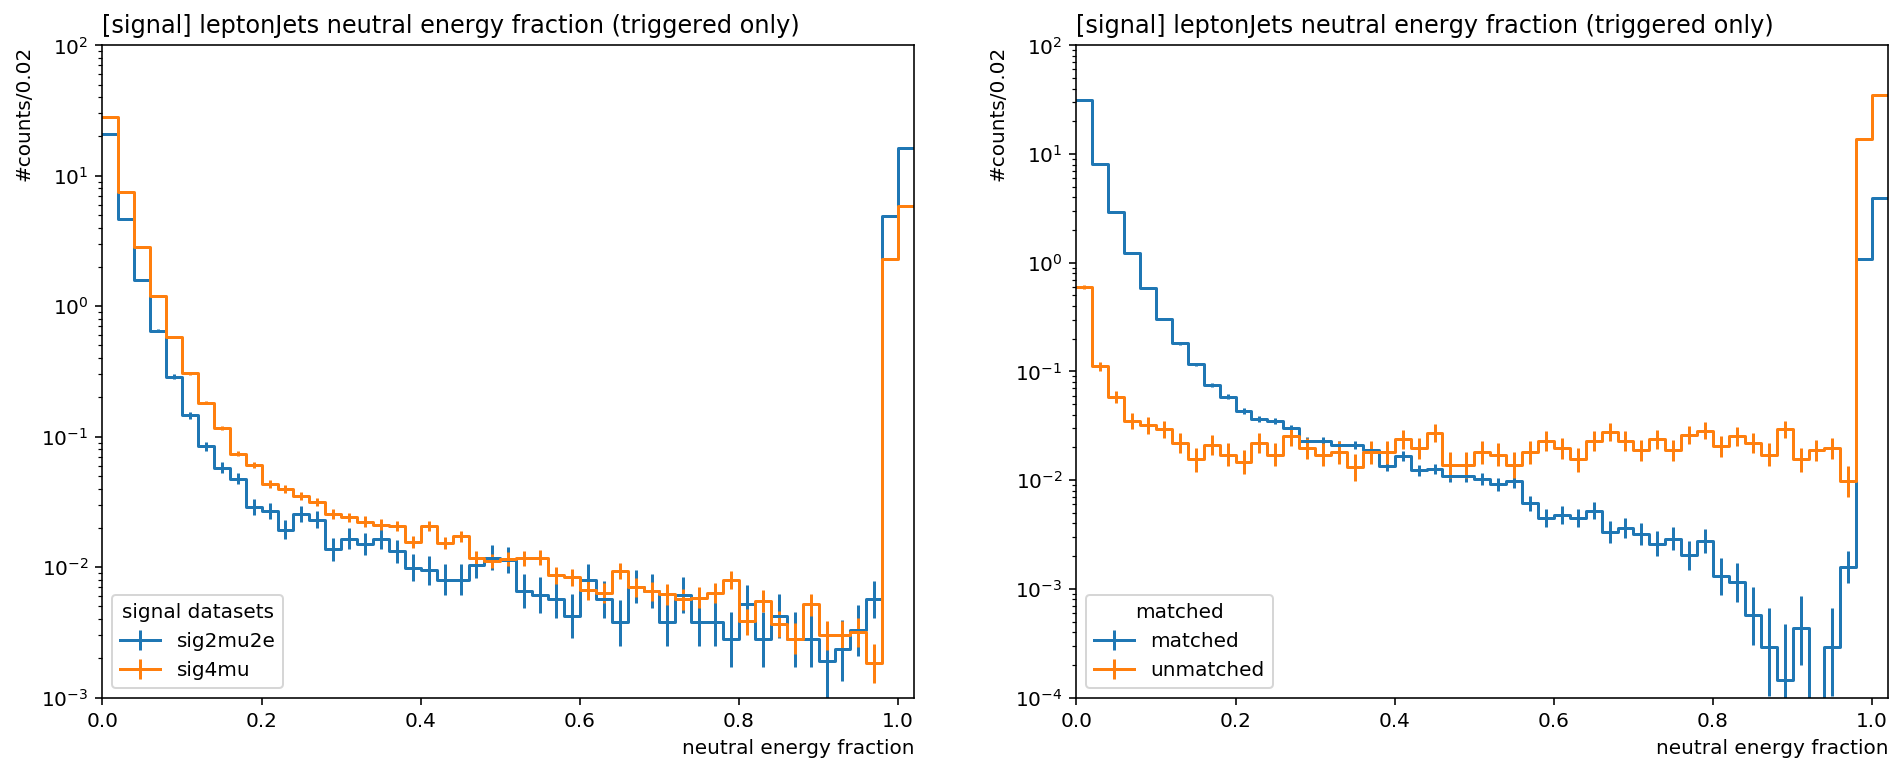

In [15]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['nef'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='over')
fig, ax, _ = hist.plot1d(output['nef'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='over')
axes[0].set_ylim([1e-3, 1e2])
axes[1].set_ylim([1e-4, 1e2])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[signal] leptonJets neutral energy fraction (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

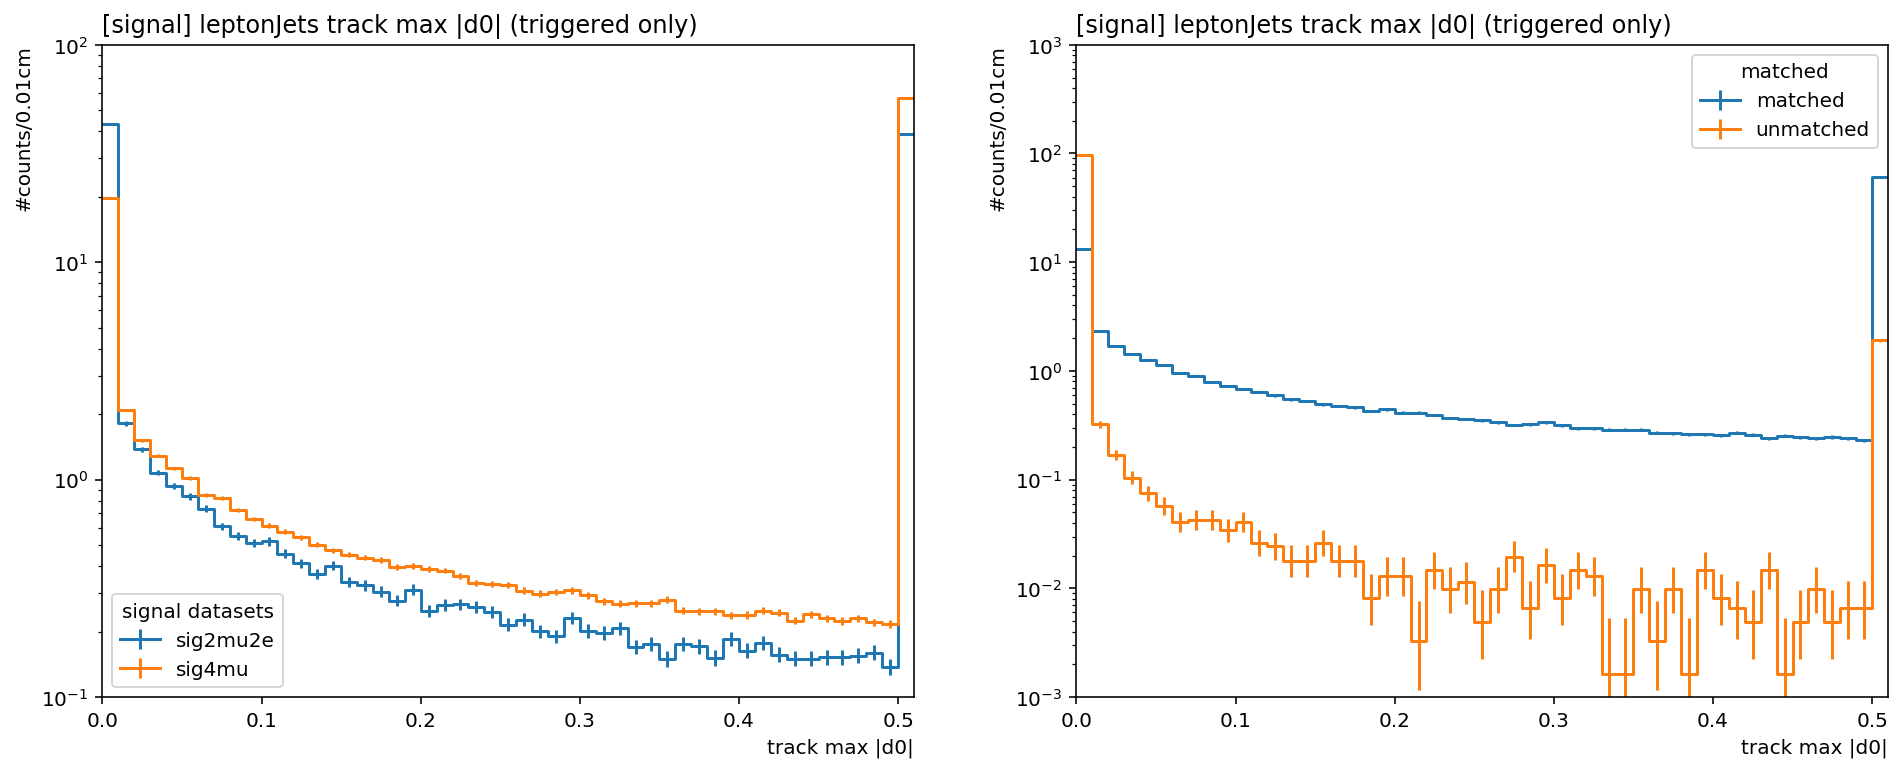

In [14]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['maxd0'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='over')
fig, ax, _ = hist.plot1d(output['maxd0'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='over')
axes[0].set_ylim([1e-1, 1e2])
axes[1].set_ylim([1e-3, 1e3])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[signal] leptonJets track max |d0| (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

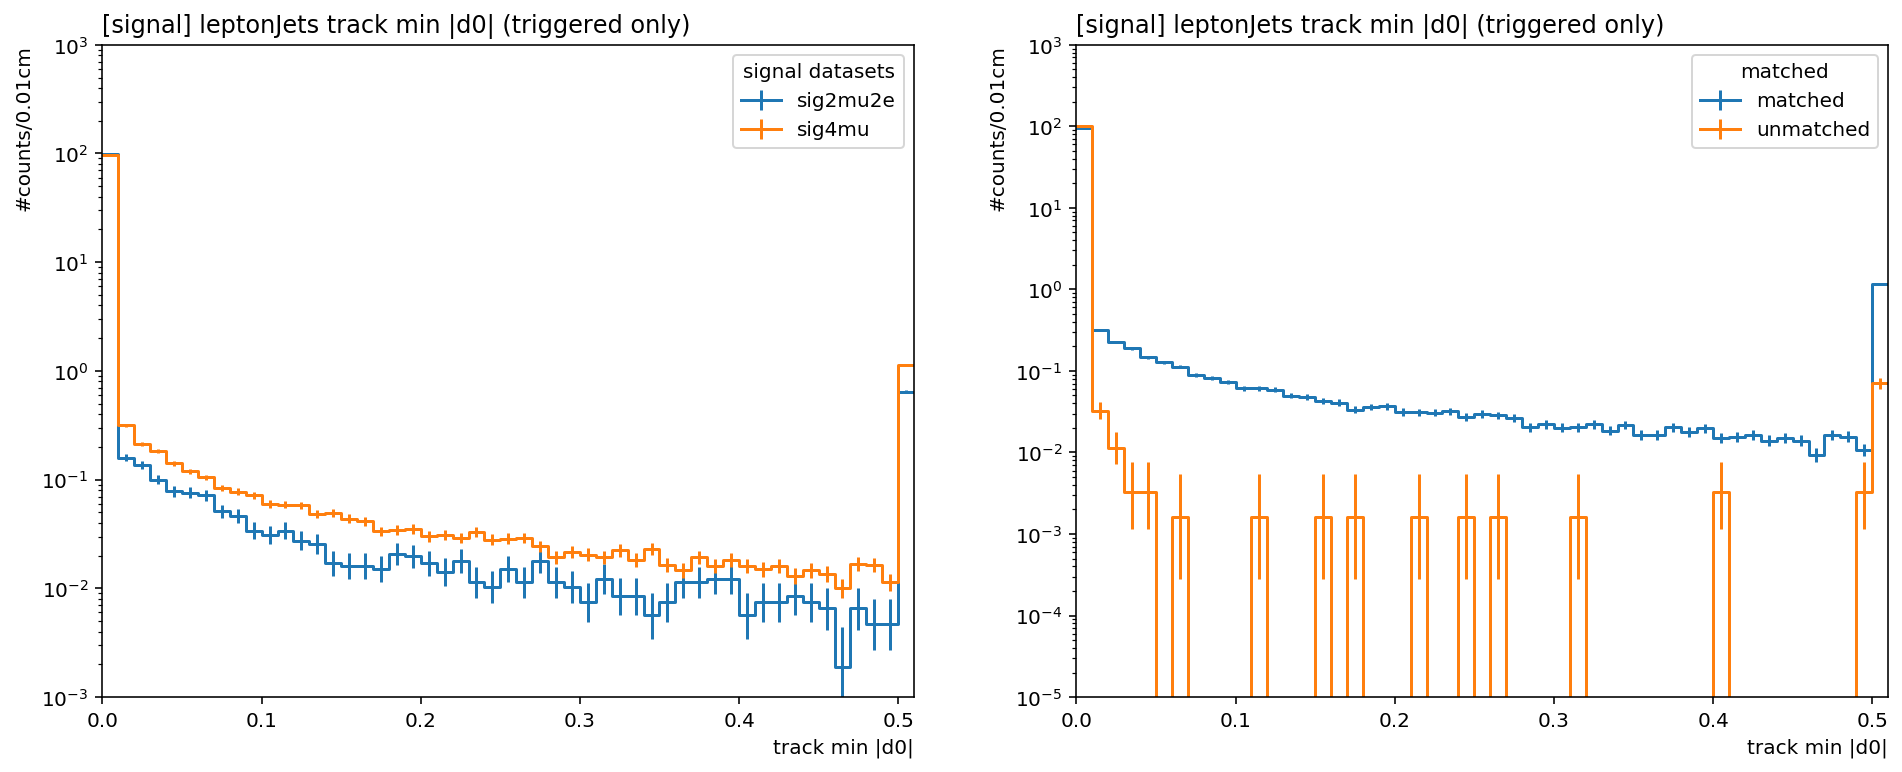

In [17]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['mind0'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='over')
fig, ax, _ = hist.plot1d(output['mind0'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='over')
axes[0].set_ylim([1e-3, 1e3])
axes[1].set_ylim([1e-5, 1e3])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[signal] leptonJets track min |d0| (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

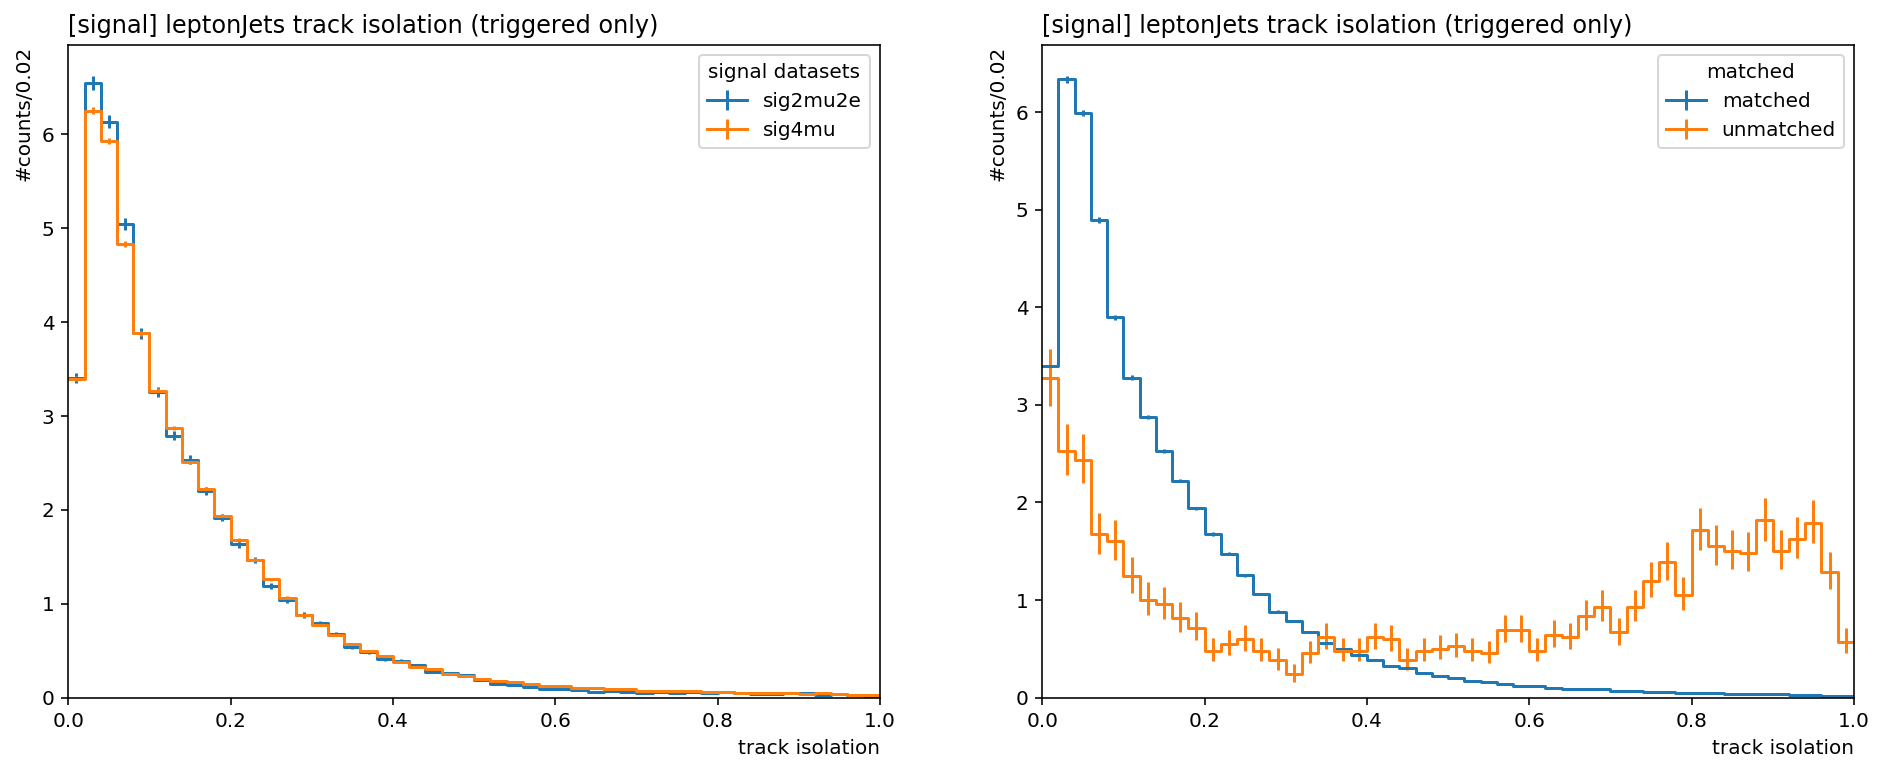

In [18]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['tkiso'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['tkiso'].project('dataset'), overlay='match', ax=axes[1], density=True)

for ax in axes:
    ax.set_title('[signal] leptonJets track isolation (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

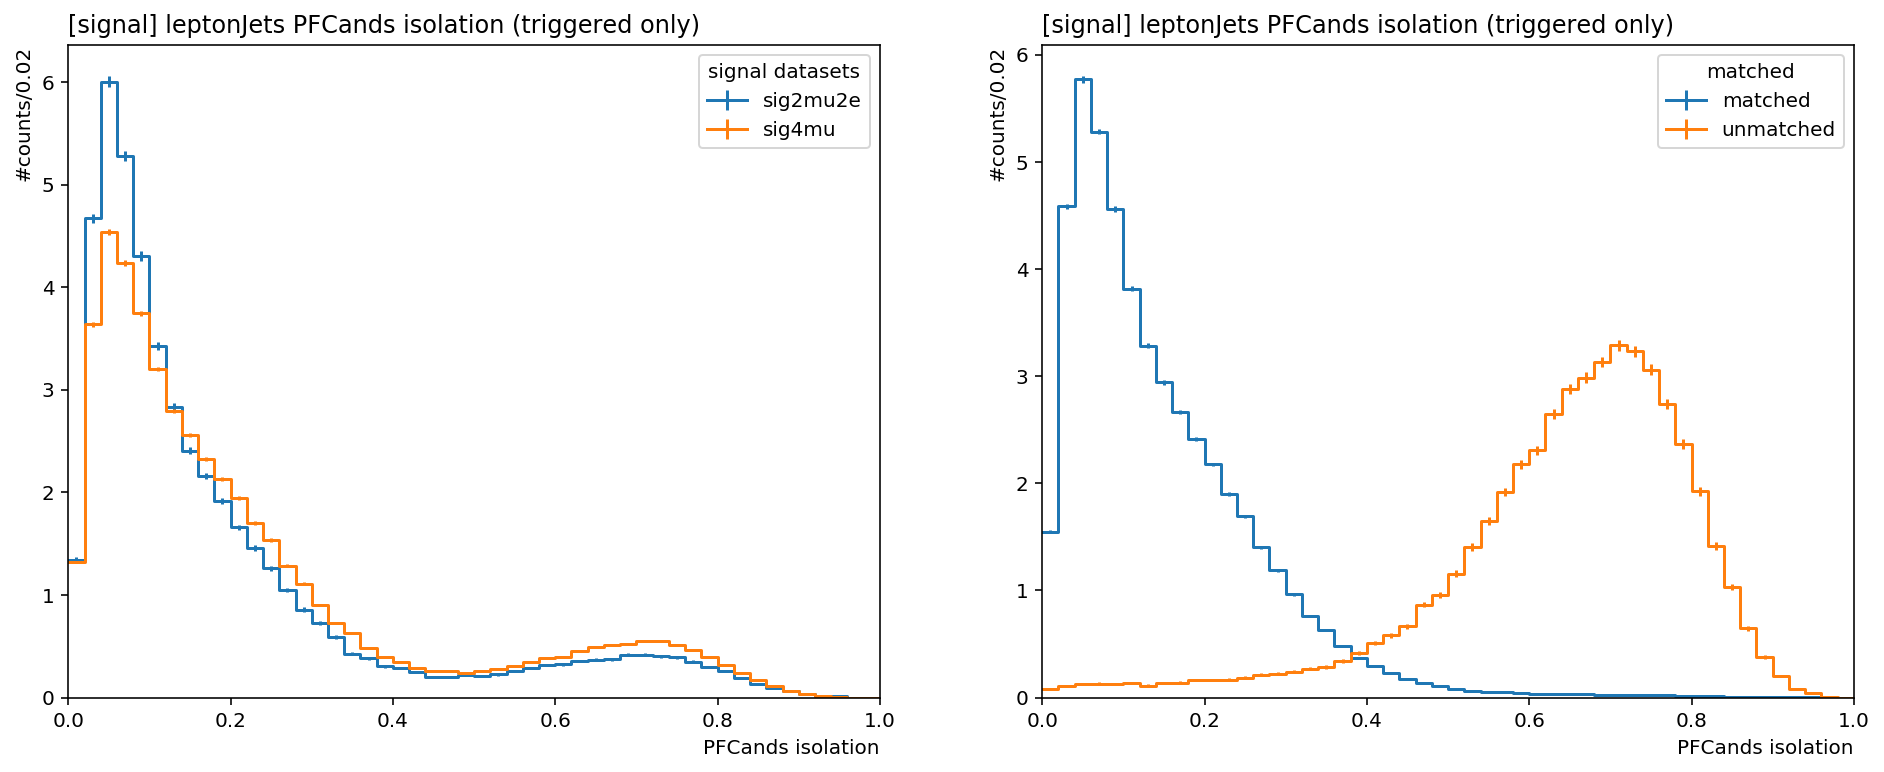

In [19]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['pfiso'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['pfiso'].project('dataset'), overlay='match', ax=axes[1], density=True)

for ax in axes:
    ax.set_title('[signal] leptonJets PFCands isolation (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

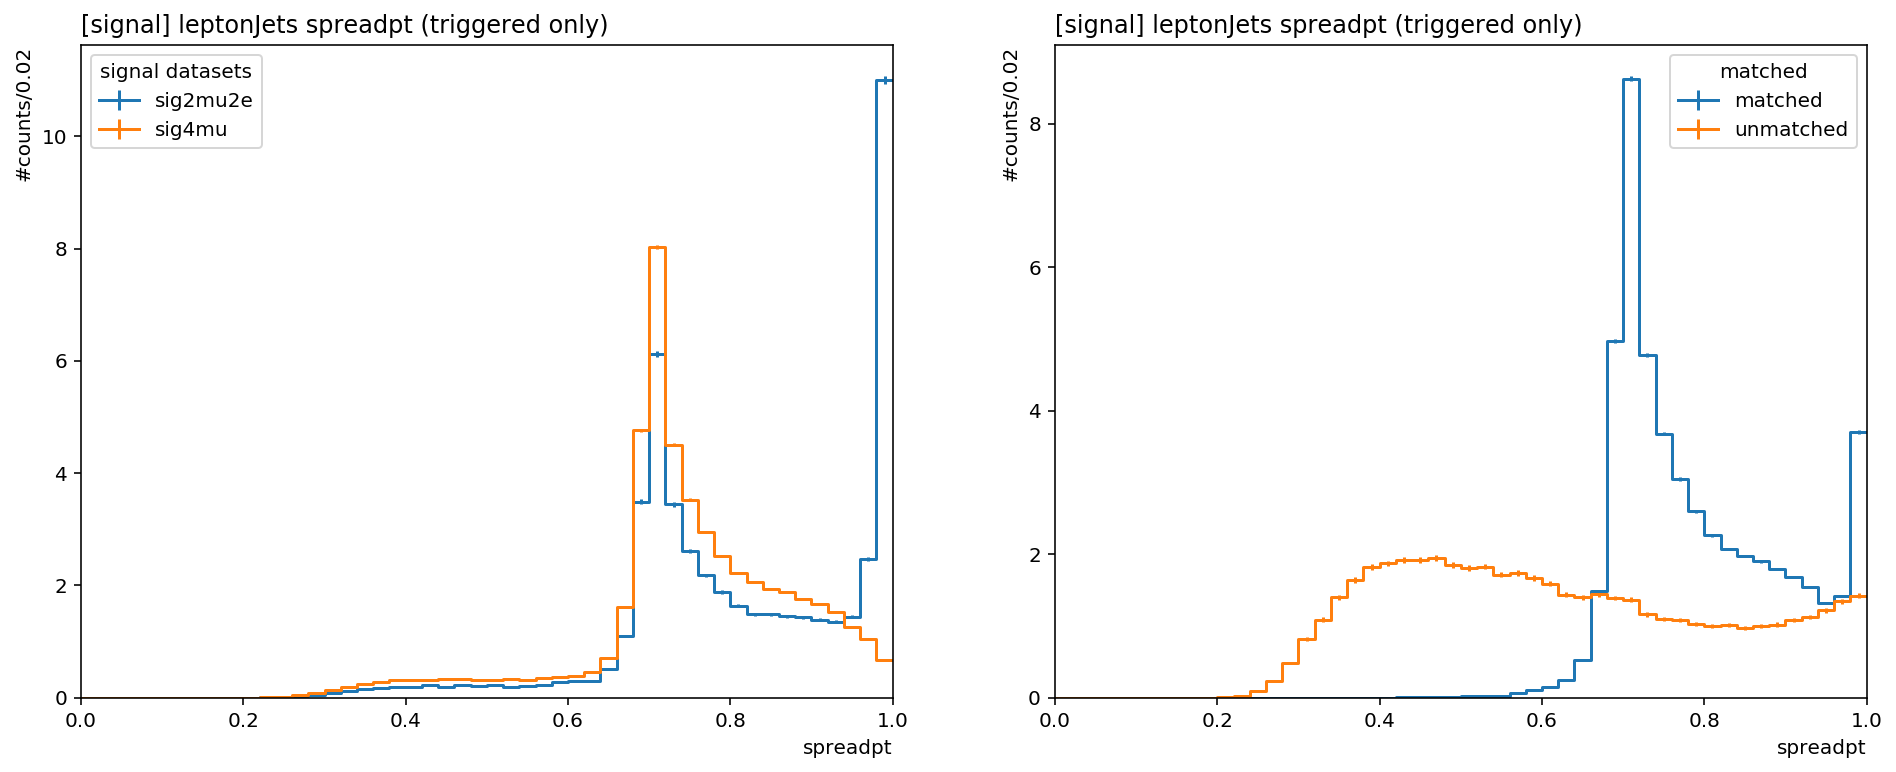

In [20]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['spreadpt'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['spreadpt'].project('dataset'), overlay='match', ax=axes[1], density=True)

for ax in axes:
    ax.set_title('[signal] leptonJets spreadpt (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

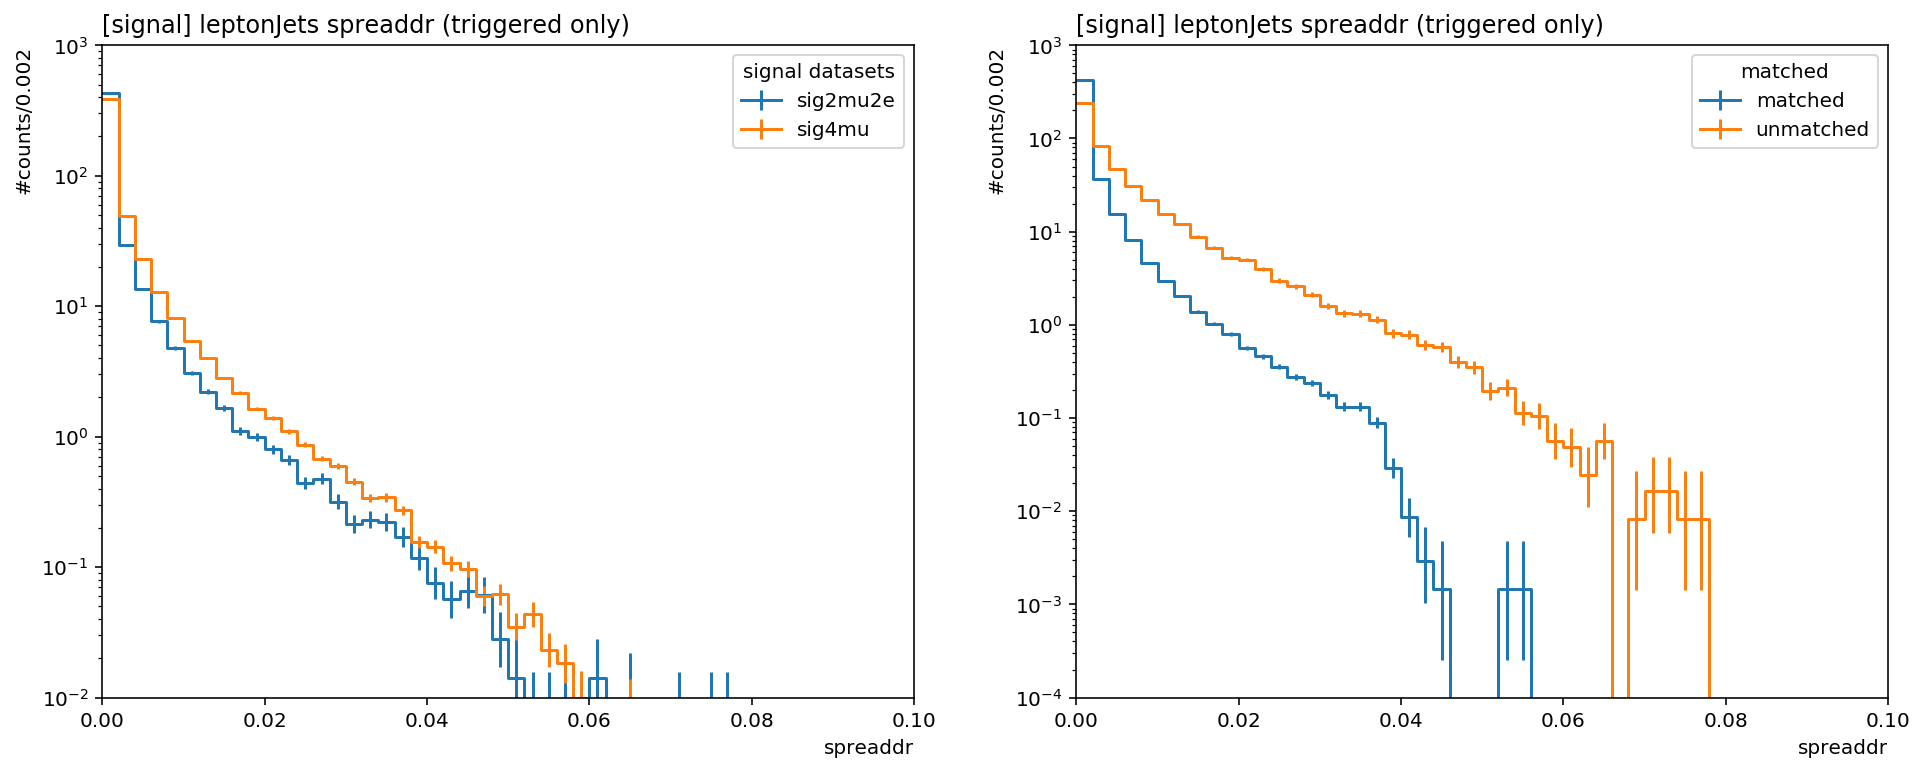

In [21]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['spreaddr'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['spreaddr'].project('dataset'), overlay='match', ax=axes[1], density=True)
axes[0].set_ylim([1e-2, 1e3])
axes[1].set_ylim([1e-4, 1e3])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[signal] leptonJets spreaddr (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

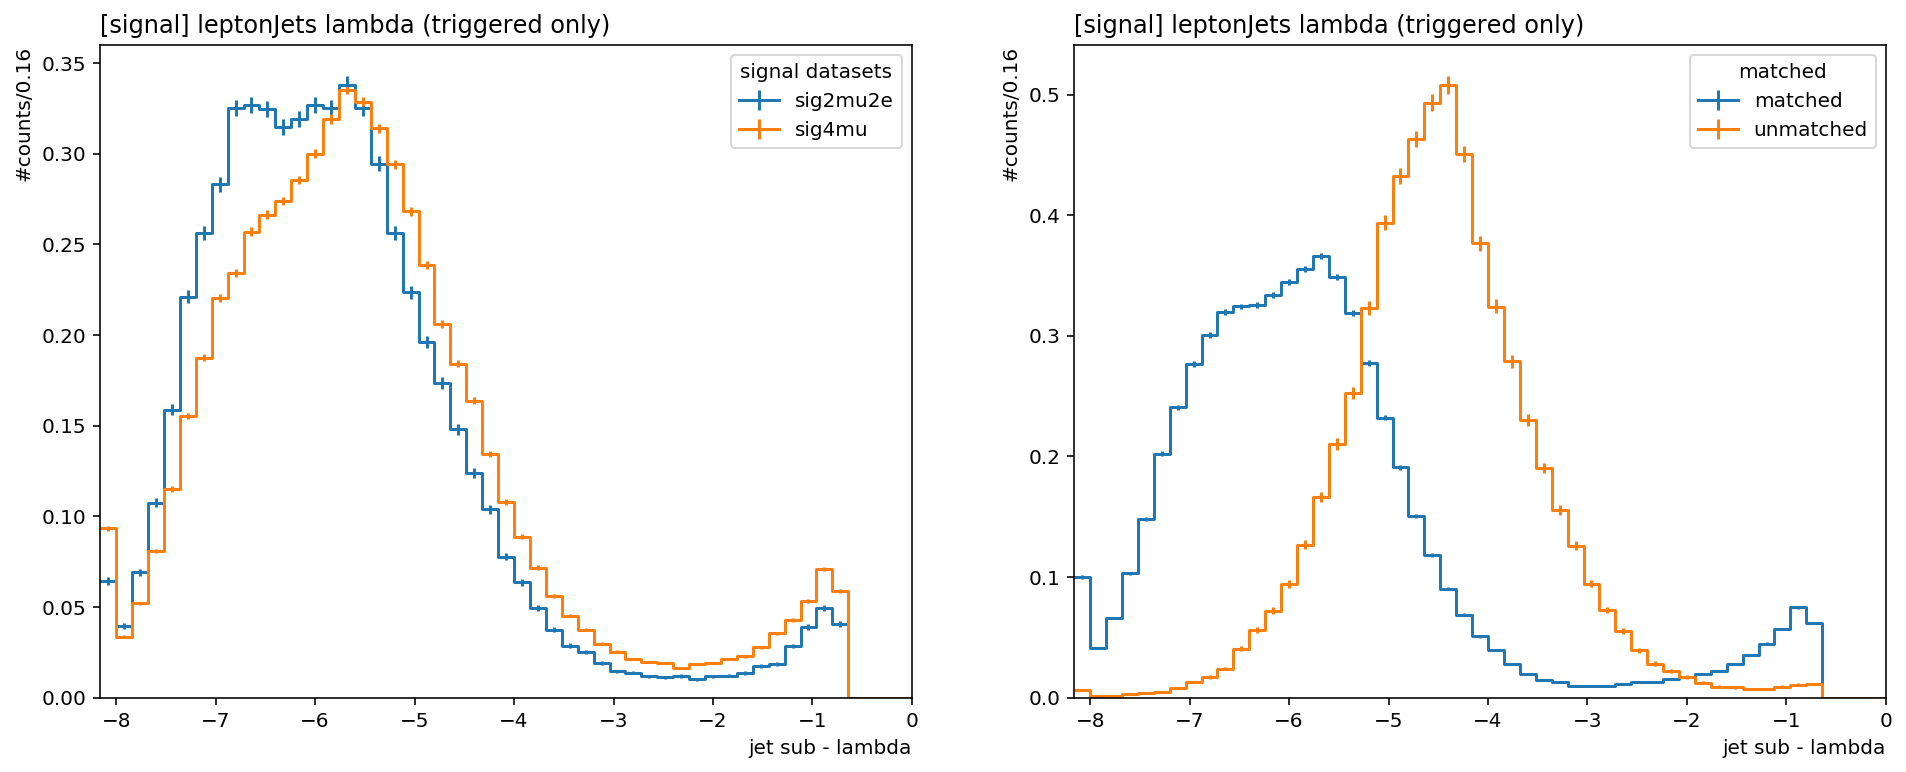

In [24]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['lamb'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='under')
fig, ax, _ = hist.plot1d(output['lamb'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='under')

for ax in axes:
    ax.set_title('[signal] leptonJets lambda (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

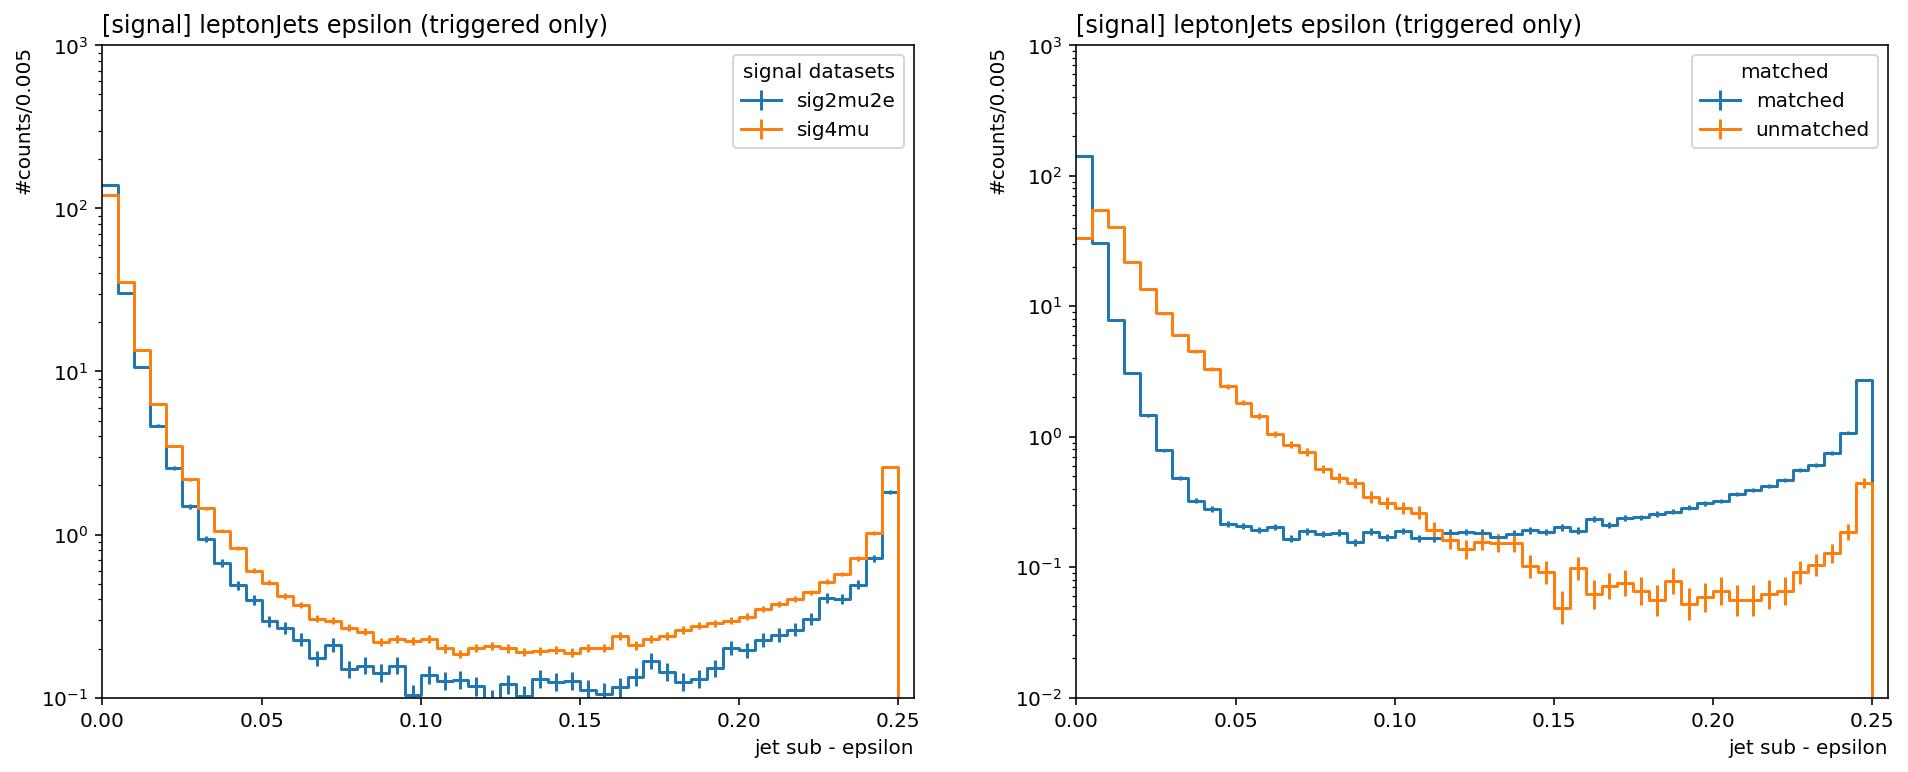

In [25]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['epsi'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='over')
fig, ax, _ = hist.plot1d(output['epsi'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='over')
axes[0].set_ylim([1e-1, 1e3])
axes[1].set_ylim([1e-2, 1e3])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[signal] leptonJets epsilon (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

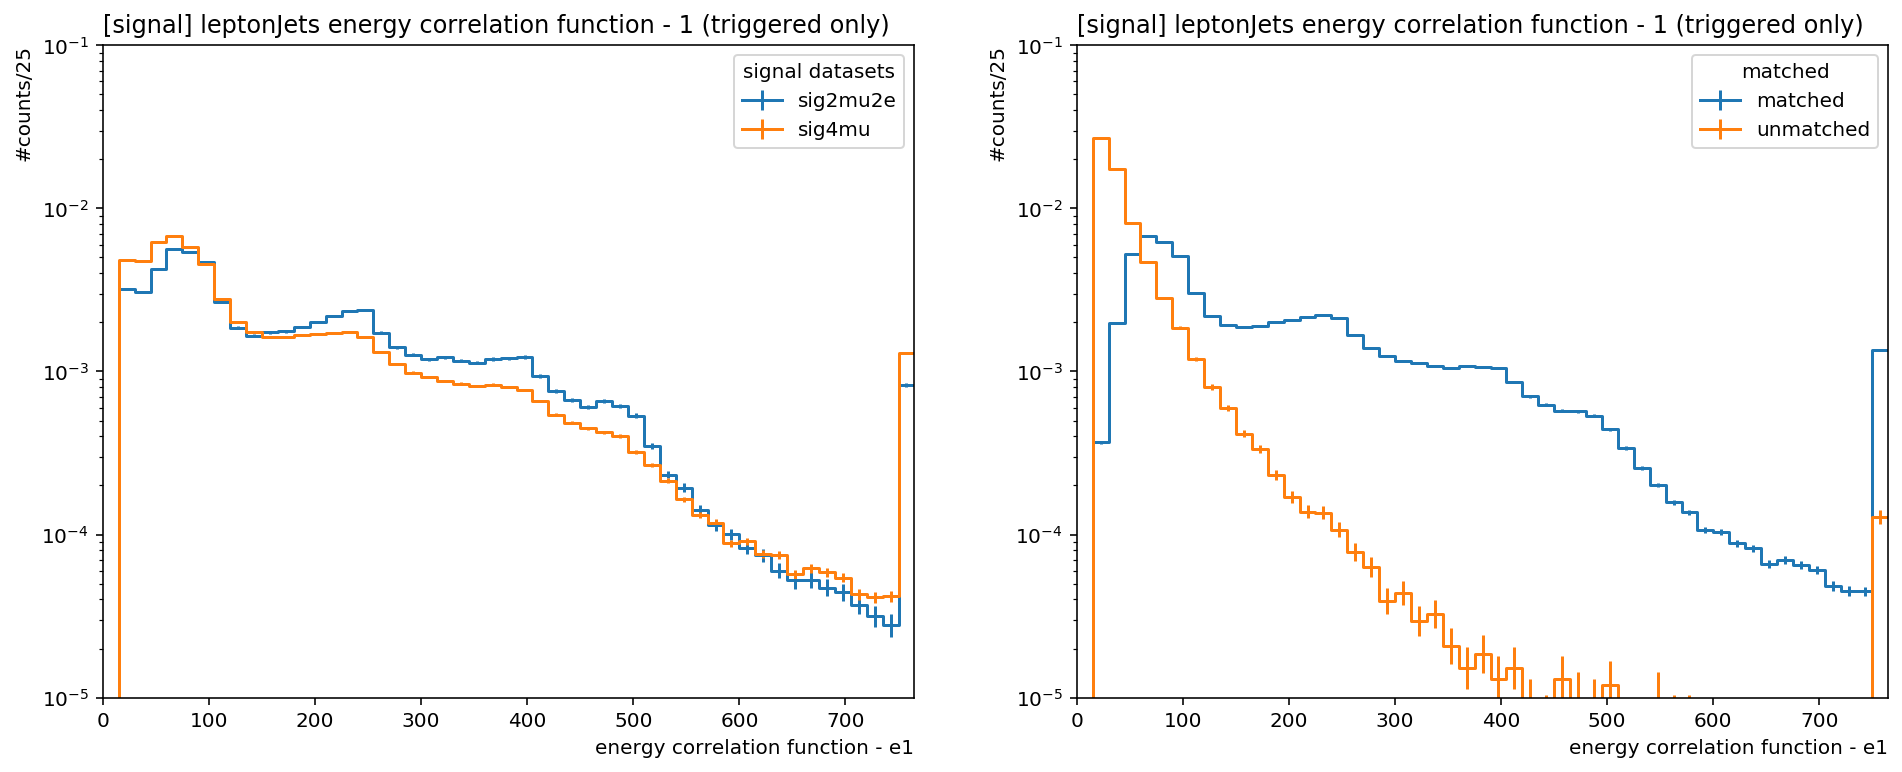

In [40]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['ecfe1'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='over')
fig, ax, _ = hist.plot1d(output['ecfe1'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='over')

for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim([1e-5, 1e-1])
    ax.set_title('[signal] leptonJets energy correlation function - 1 (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

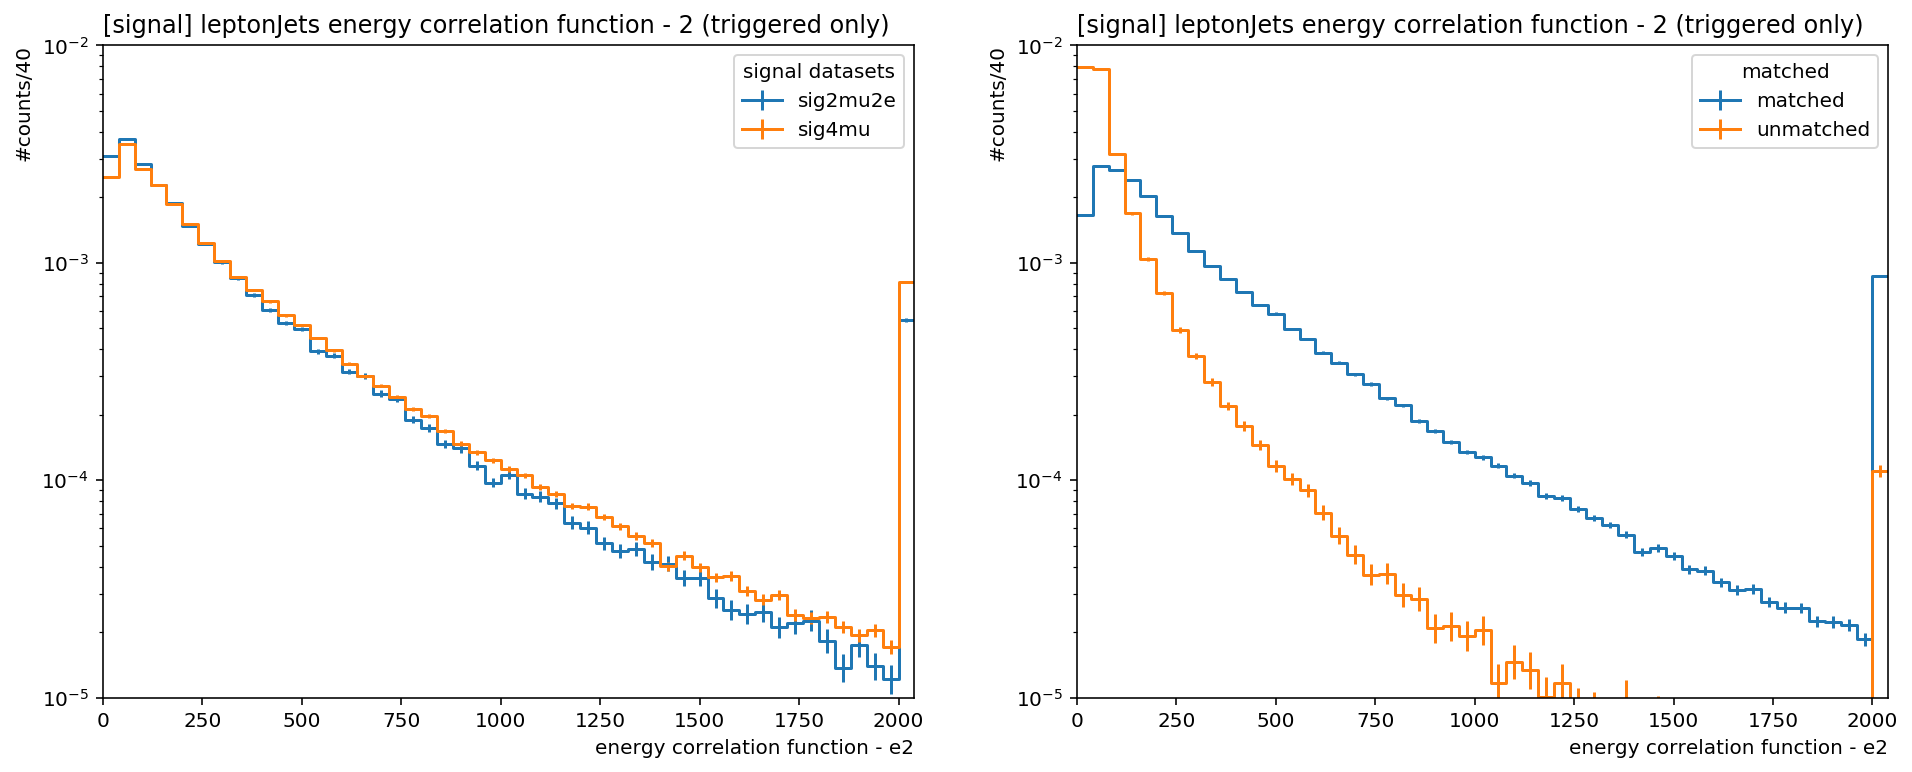

In [36]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['ecfe2'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='over')
fig, ax, _ = hist.plot1d(output['ecfe2'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='over')

for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim([1e-5, 1e-2])
    ax.set_title('[signal] leptonJets energy correlation function - 2 (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

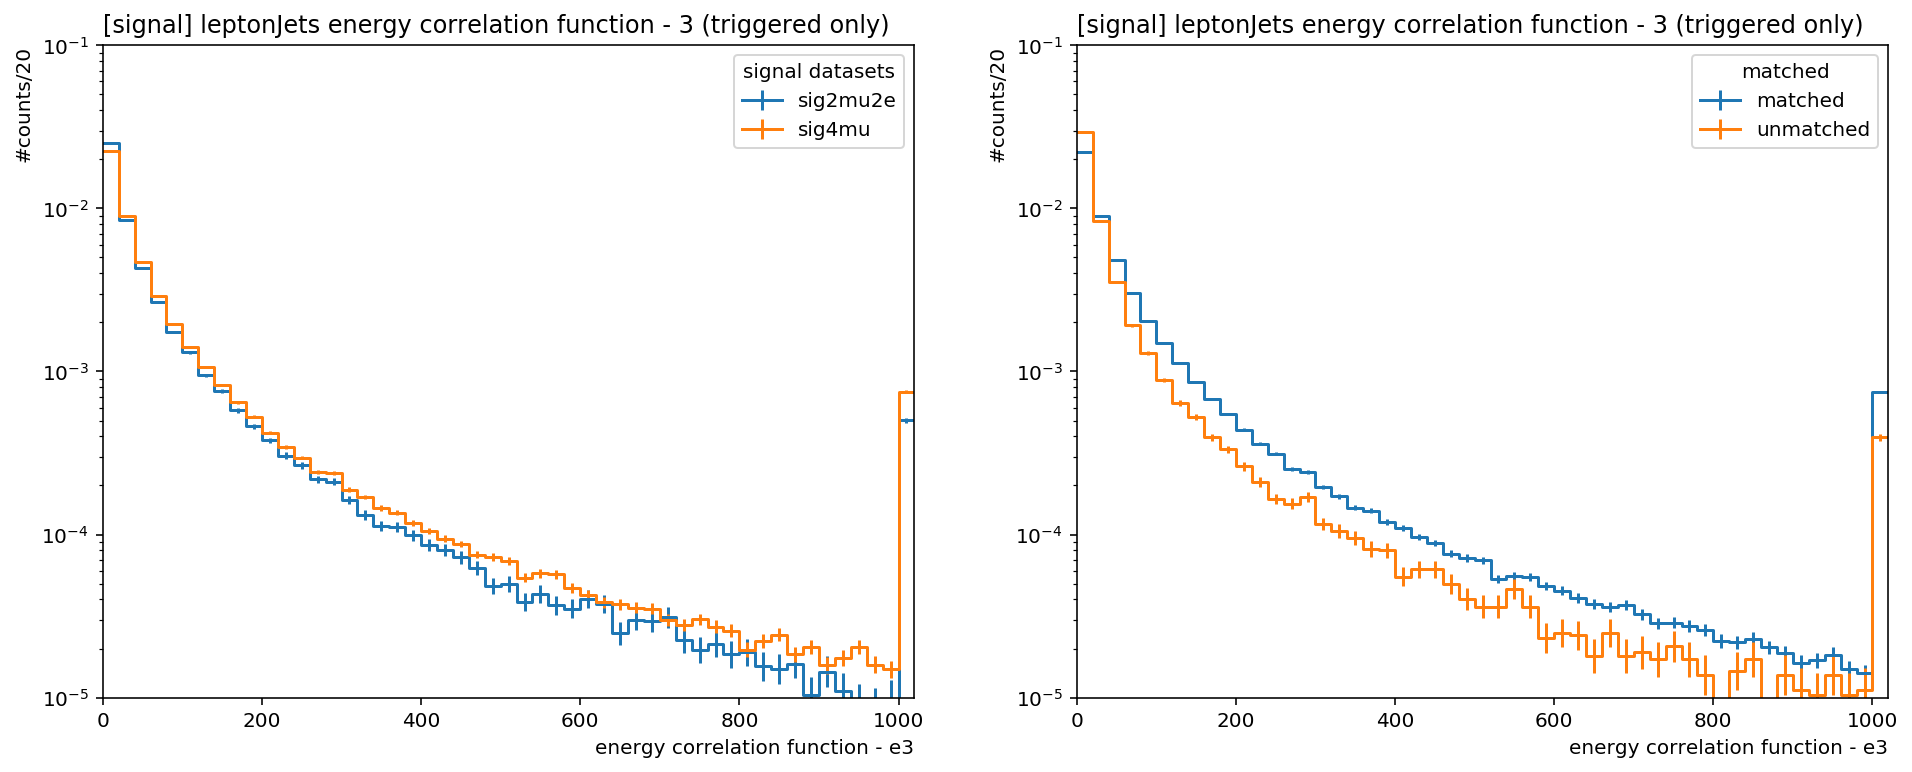

In [49]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['ecfe3'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='over')
fig, ax, _ = hist.plot1d(output['ecfe3'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='over')

for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim([1e-5, 1e-1])
    ax.set_title('[signal] leptonJets energy correlation function - 3 (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

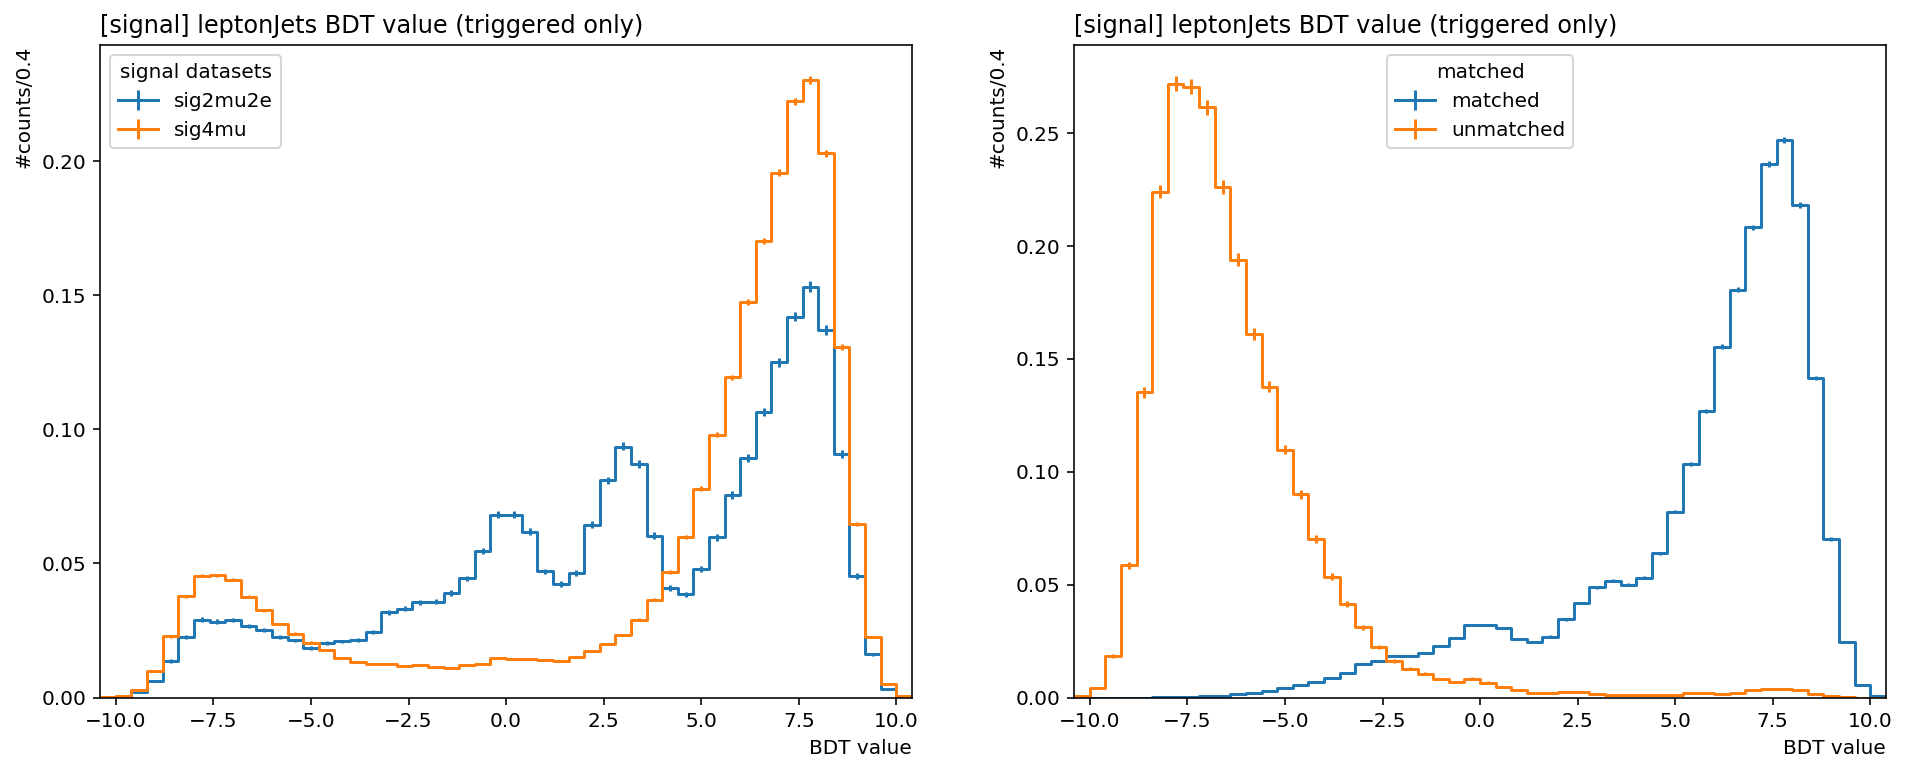

In [29]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['mva'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='all')
fig, ax, _ = hist.plot1d(output['mva'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='all')

for ax in axes:
    ax.set_title('[signal] leptonJets BDT value (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

### leptonJet pair (lead, sublead)
- invariant mass
- delta phi

In [50]:
class LeptonJetPairProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'signal datasets')
        mass_axis = hist.Bin("mass", "invM [GeV]", 50, 0, 300)
        masss_axis = hist.Bin("mass", "invM [GeV]", 50, 0, 1200)
        dphi_axis = hist.Bin('dphi', "$\Delta\Phi$", 50, 0, 3.142)
        
        self._accumulator = processor.dict_accumulator({
            'mass': hist.Hist("A.U./10GeV", dataset_axis, mass_axis),
            'masss': hist.Hist("A.U./10GeV", dataset_axis, masss_axis),
            'dphi': hist.Hist("A.U./$\pi$/50", dataset_axis, dphi_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        leptonjets = leptonjets[metfiltermask&triggermask]
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size!=0:
            leadingLjPair = leptonjetpair[sumpt.argmax()]
            dphi = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))
            
            output['mass'].fill(dataset=dataset, mass=leadingLjPair.mass.flatten())
            output['masss'].fill(dataset=dataset, mass=leadingLjPair.mass.flatten())
            output['dphi'].fill(dataset=dataset, dphi=dphi.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [51]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetPairProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 300/300 [00:17<00:00, 17.52items/s]


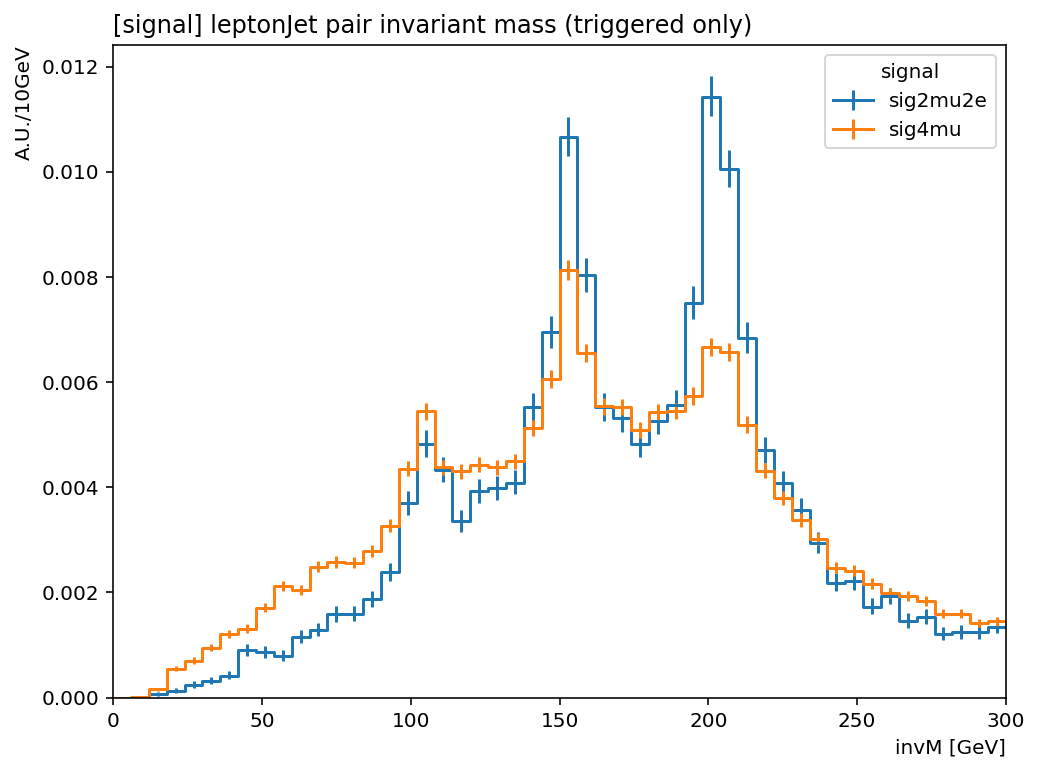

In [53]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['mass'], overlay='dataset', ax=ax, density=True)
ax.set_title('[signal] leptonJet pair invariant mass (triggered only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

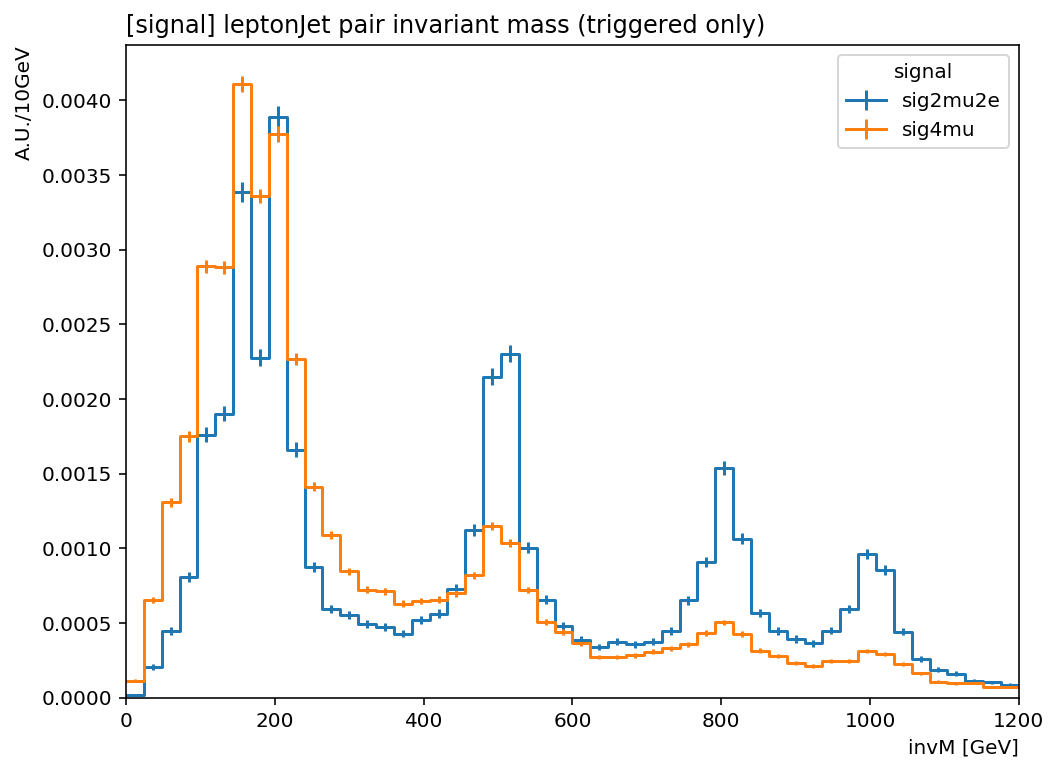

In [54]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['masss'], overlay='dataset', ax=ax, density=True)
ax.set_title('[signal] leptonJet pair invariant mass (triggered only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

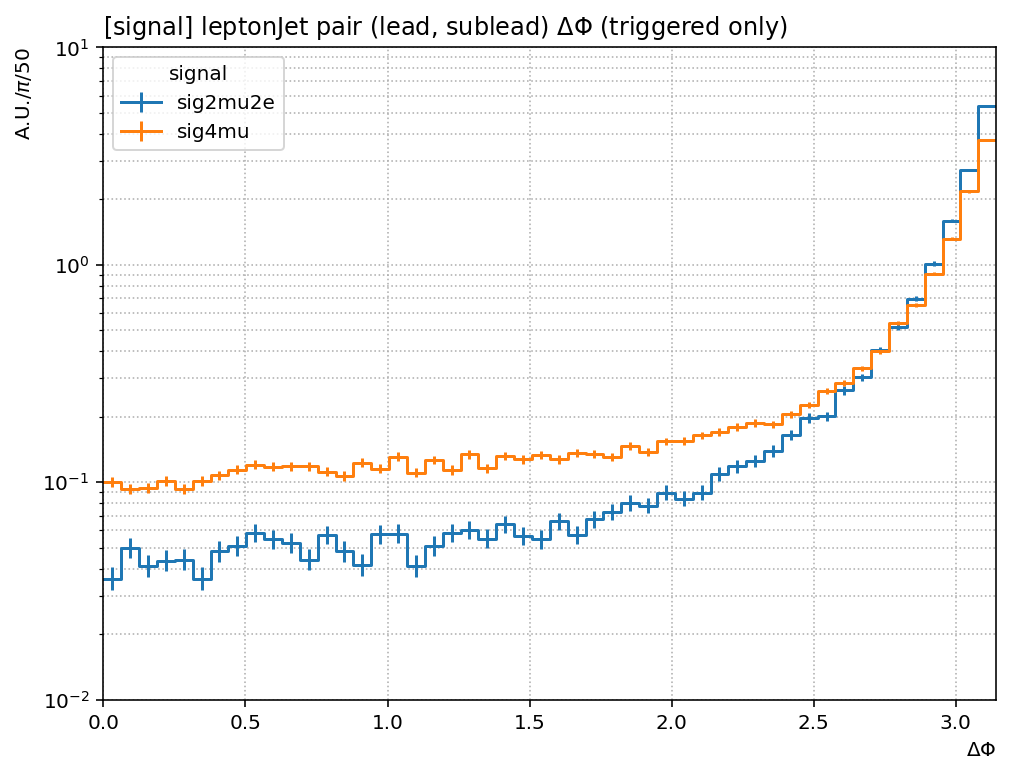

In [57]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['dphi'], overlay='dataset', ax=ax, density=True)
ax.set_title('[signal] leptonJet pair (lead, sublead) $\Delta\Phi$ (triggered only)', x=0.0, ha="left")
ax.set_yscale('log')
ax.grid(which='both', ls=':')
ax.set_ylim([1e-2, 1e1])
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

In [3]:
class LeptonJetPairProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'signal datasets')
        masslow_axis = hist.Bin("mass", "invM [GeV]", 30, 0, 300)
        masshigh_axis = hist.Bin("mass", "invM [GeV]", 90, 300, 1200)
        massall_axis = hist.Bin("mass", "invM [GeV]", 120, 0, 1200)
        dphi_axis = hist.Bin('dphi', "$\Delta\Phi$", 50, 0, 3.142)
        
        self._accumulator = processor.dict_accumulator({
            'masslow': hist.Hist("#counts/10GeV", dataset_axis, masslow_axis),
            'masshigh': hist.Hist("#counts/10GeV", dataset_axis, masshigh_axis),
            'massall': hist.Hist("#counts/10GeV", dataset_axis, massall_axis),
            'dphi': hist.Hist("#counts/$\pi$/50", dataset_axis, dphi_axis),
        })
        self.pucorrs = get_pu_weights_function()
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        dataset = df['dataset']
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        wgts.add('genw', df['weight'])
        
        nvtx = df['npv']
        pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
        wgts.add('pileup', pu, puUp, puDown)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        wgts.add('trigger', triggermask)
        
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt

        leadingLjPair = leptonjetpair[sumpt.argmax()]
        dphi = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))

        output['masslow'].fill(dataset=dataset, mass=leadingLjPair.mass.flatten(), weight=wgt)
        output['masshigh'].fill(dataset=dataset, mass=leadingLjPair.mass.flatten(), weight=wgt)
        output['massall'].fill(dataset=dataset, mass=leadingLjPair.mass.flatten(), weight=wgt)
        output['dphi'].fill(dataset=dataset, dphi=dphi.flatten(), weight=wgt)
        
        return output
    
    def postprocess(self, accumulator):
        for k in accumulator:
            accumulator[k].scale(scales, axis='dataset')
        return accumulator

In [4]:
output = processor.run_uproot_job(datasetsplit,
                                  treename=None,
                                  processor_instance=LeptonJetPairProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 312/312 [00:22<00:00, 14.04items/s]


In [6]:
import re
lowmass = re.compile('(\w+/mXX-(100|150|200)_mA-\w+_lxy-\w+)')
highmass = re.compile('(\w+/mXX-(500|800|1000)_mA-\w+_lxy-\w+)')
allmass = re.compile('(\w+/mXX-\w+_mA-\w+_lxy-\w+)')

mXX in [100, 150, 200]

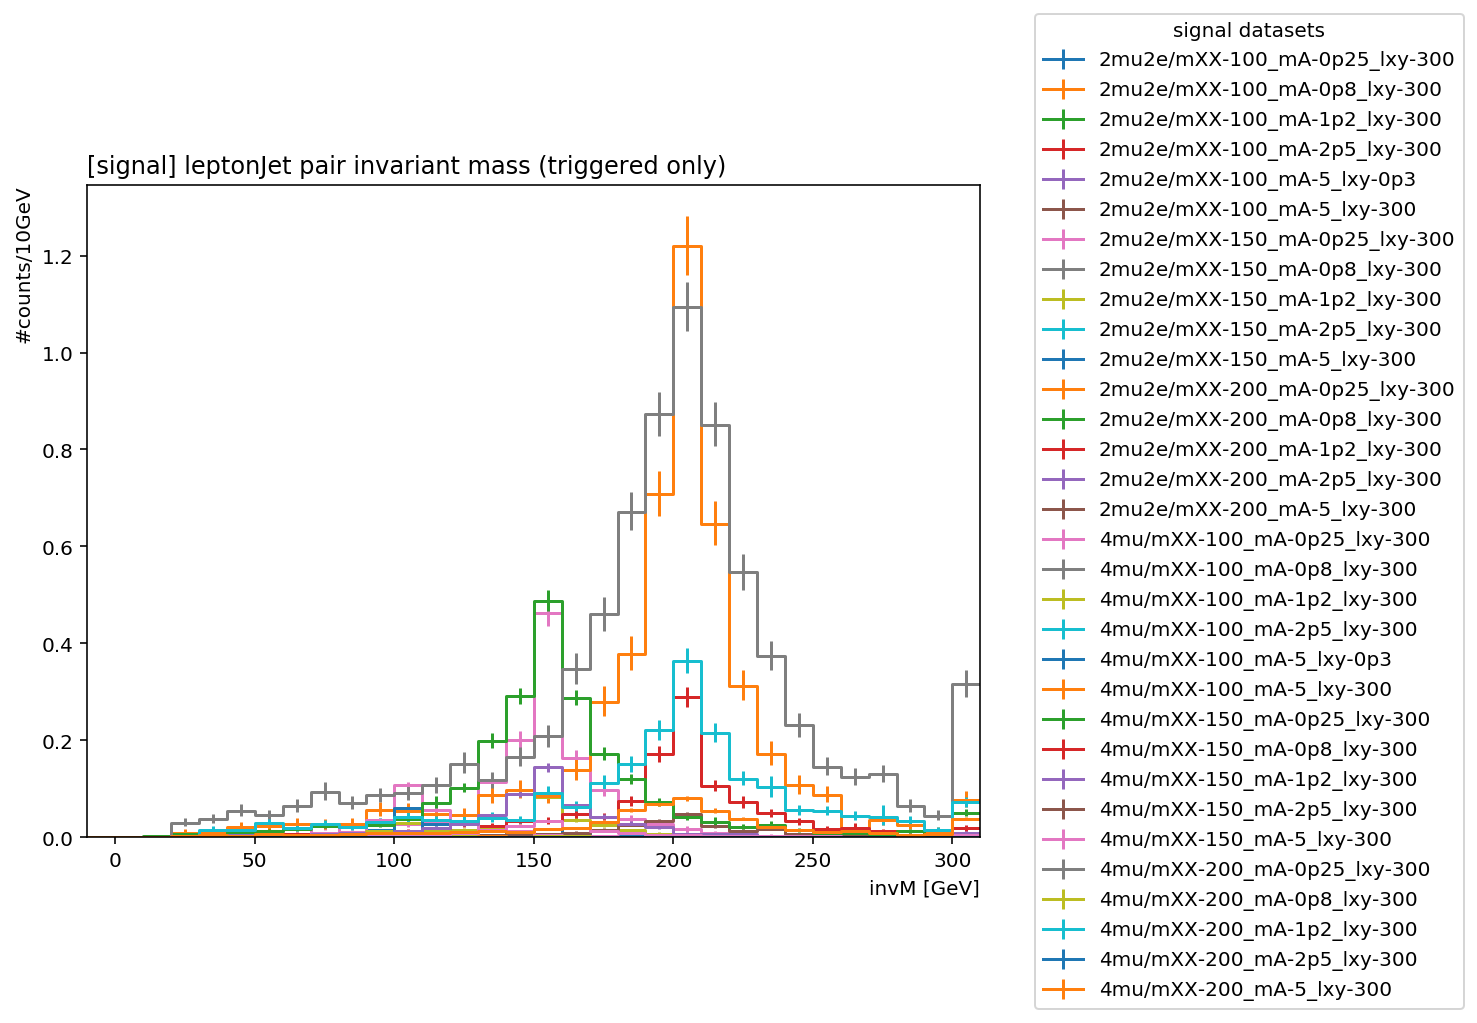

In [8]:
matplotlib.rcParams['legend.loc'] = 'center left'

fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['masslow'][lowmass], overlay='dataset', ax=ax, density=False, overflow='all')
ax.set_title('[signal] leptonJet pair invariant mass (triggered only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.get_legend().set_bbox_to_anchor((1.05, 0.5));

mXX in [500, 800, 1000]

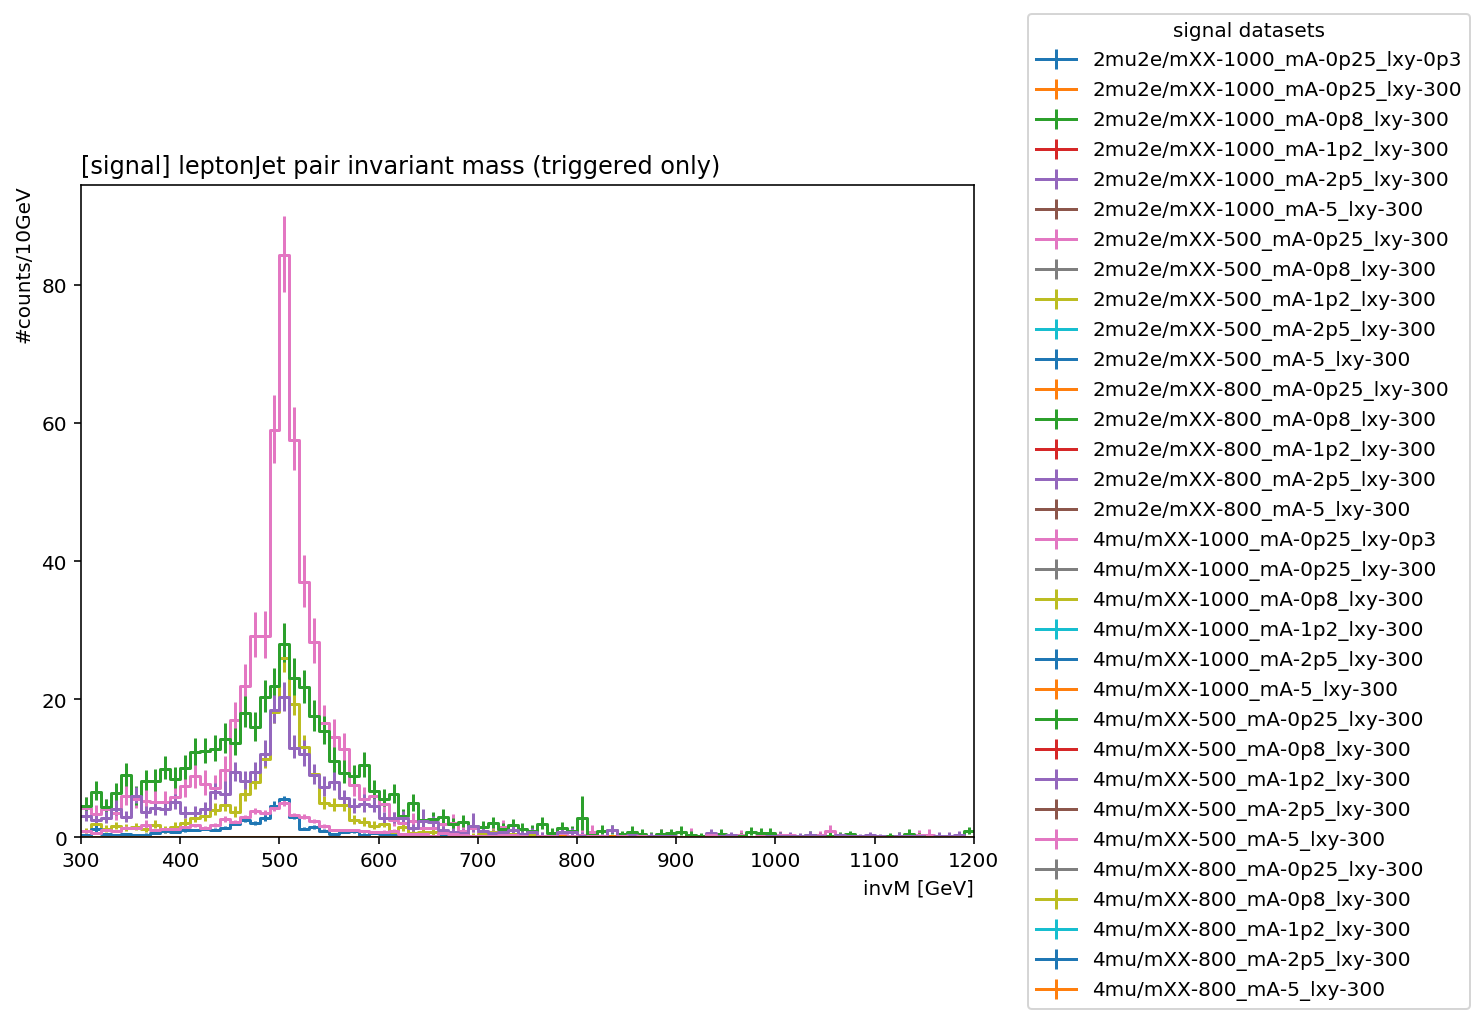

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['masshigh'][highmass], overlay='dataset', ax=ax, density=False)
ax.set_title('[signal] leptonJet pair invariant mass (triggered only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.get_legend().set_bbox_to_anchor((1.05, 0.5));

mXX in [100,150,200,500,800,1000]

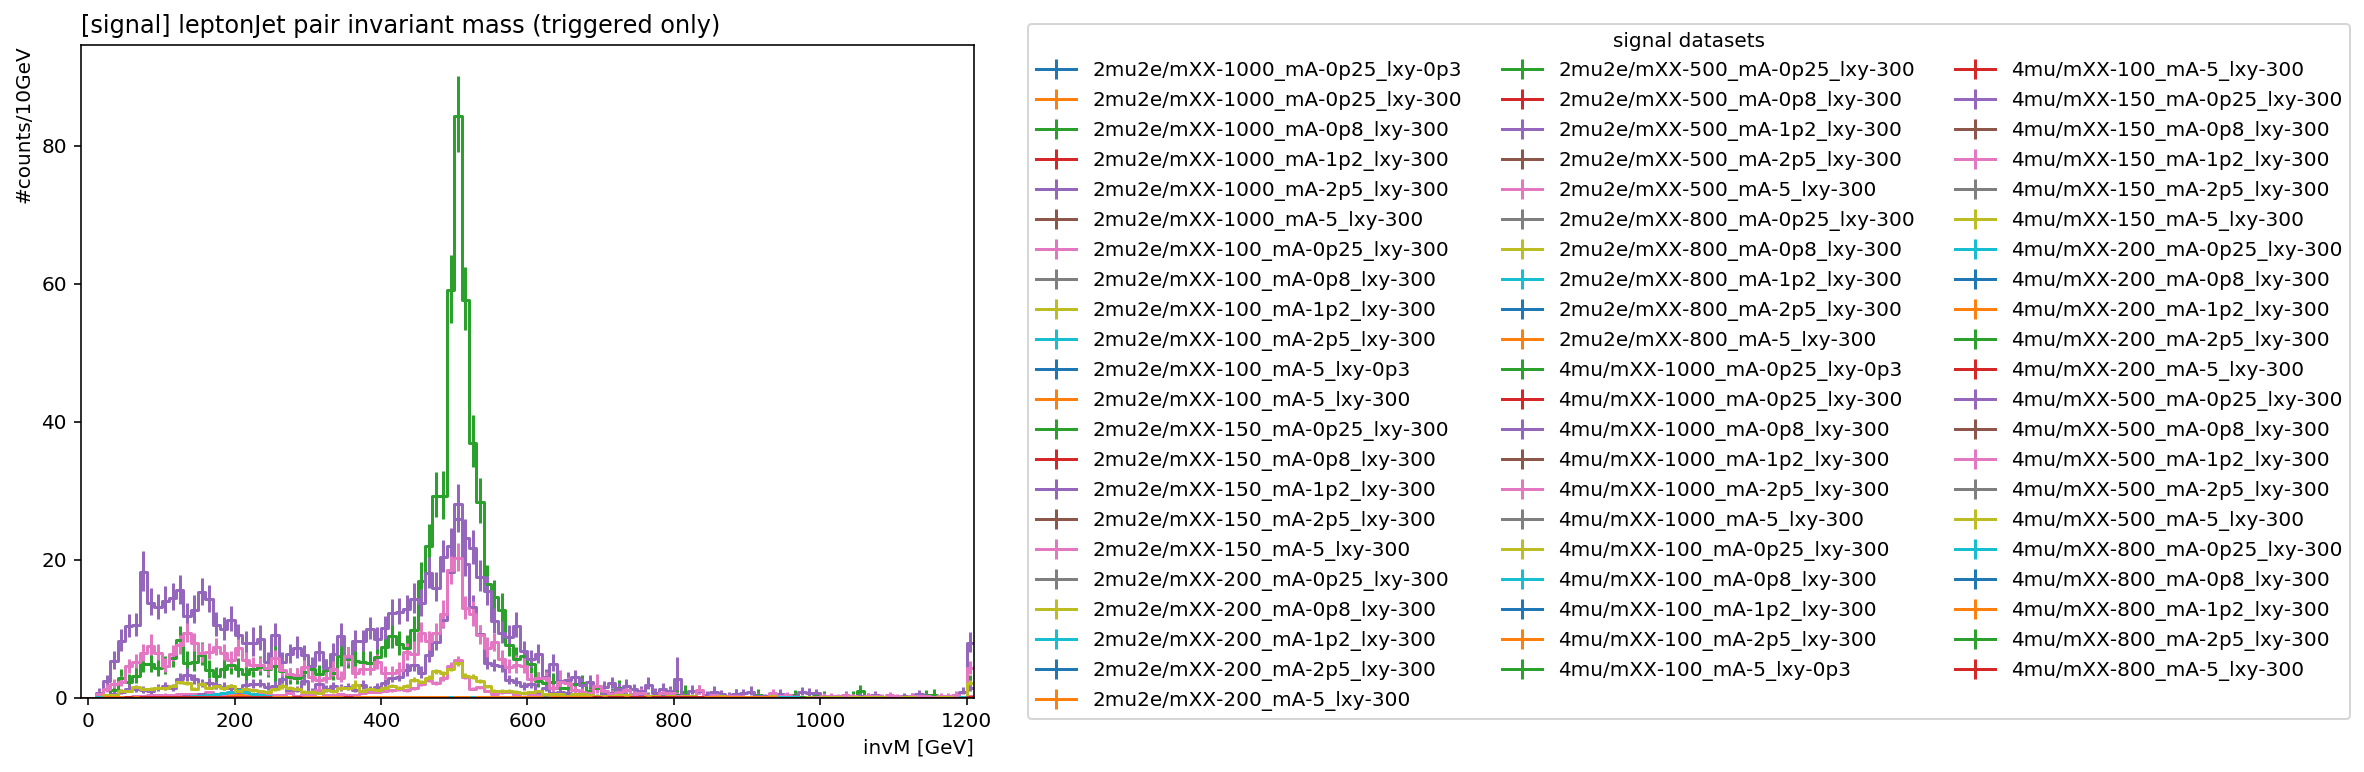

In [40]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['massall'][allmass], overlay='dataset', ax=ax, density=False, overflow='all')
ax.set_title('[signal] leptonJet pair invariant mass (triggered only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
matplotlib.rcParams['legend.loc'] = 'center left'

# re-draw legend
from collections import defaultdict
hl_ = defaultdict(list)
for h, l in zip(*ax.get_legend_handles_labels()):
    hl_[l].append(h)
l2 = hl_.keys()
h2 = list()
for h_ in hl_.values(): h2.append(tuple(h_))

legtitle = ax.get_legend().get_title().get_text()
ax.legend(h2, l2, ncol=3, bbox_to_anchor=(1.05, 0.5), title=legtitle);

mXX=100

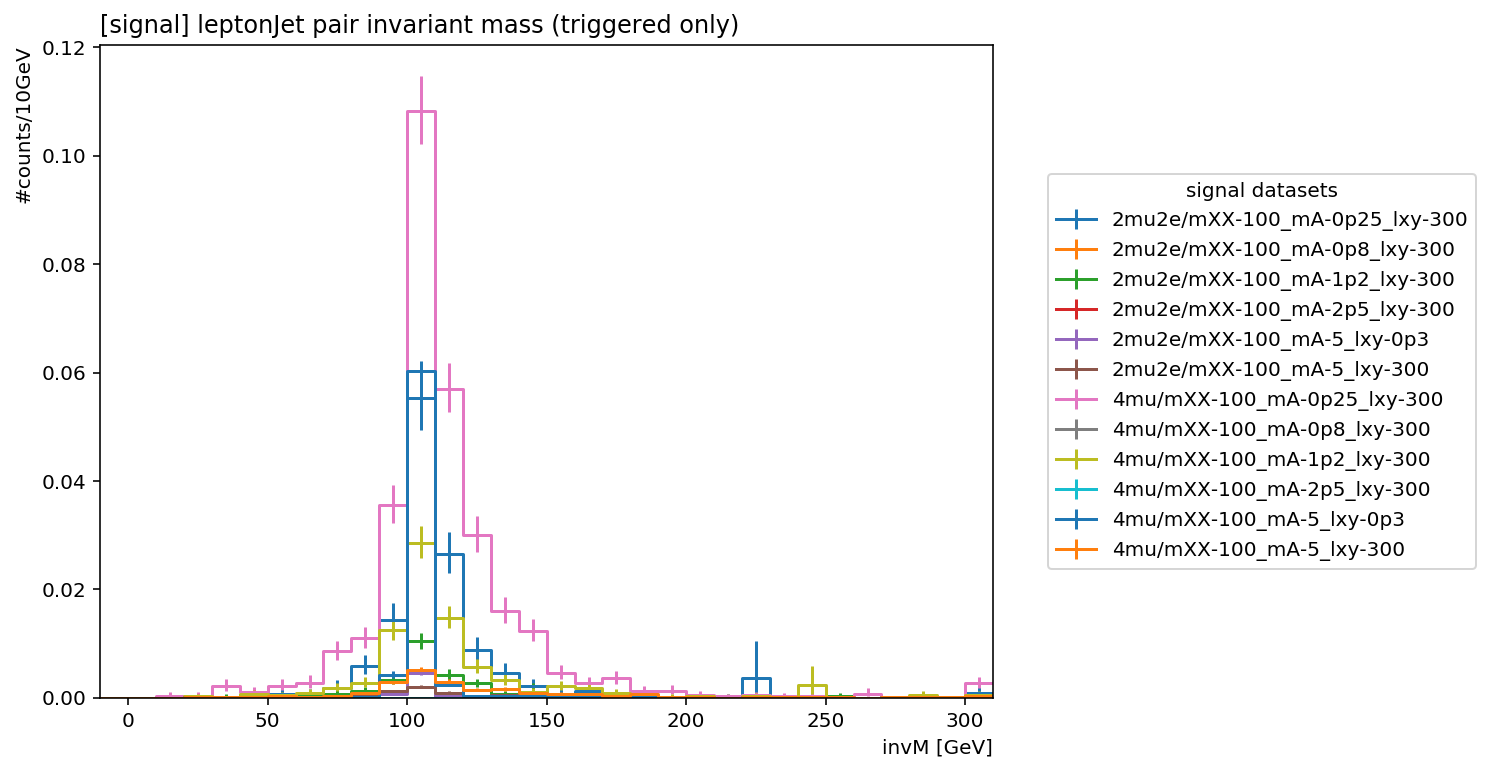

In [12]:
select = re.compile('(\w+/mXX-100_mA-\w+_lxy-\w+)')

fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['masslow'][select], overlay='dataset', ax=ax, density=False, overflow='all')
ax.set_title('[signal] leptonJet pair invariant mass (triggered only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.get_legend().set_bbox_to_anchor((1.05, 0.5));

mXX=150

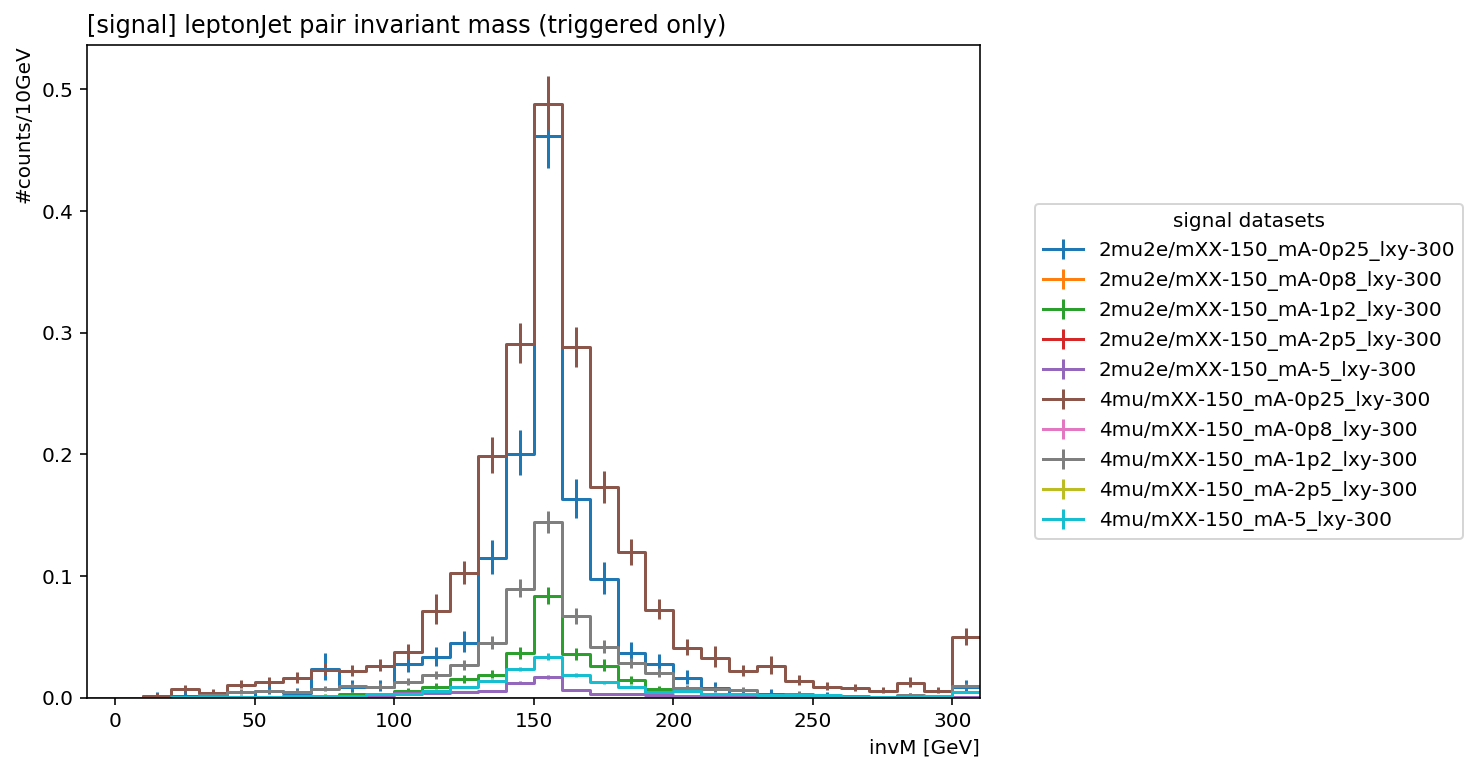

In [14]:
select = re.compile('(\w+/mXX-150_mA-\w+_lxy-\w+)')

fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['masslow'][select], overlay='dataset', ax=ax, density=False, overflow='all')
ax.set_title('[signal] leptonJet pair invariant mass (triggered only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.get_legend().set_bbox_to_anchor((1.05, 0.5));

mXX=200

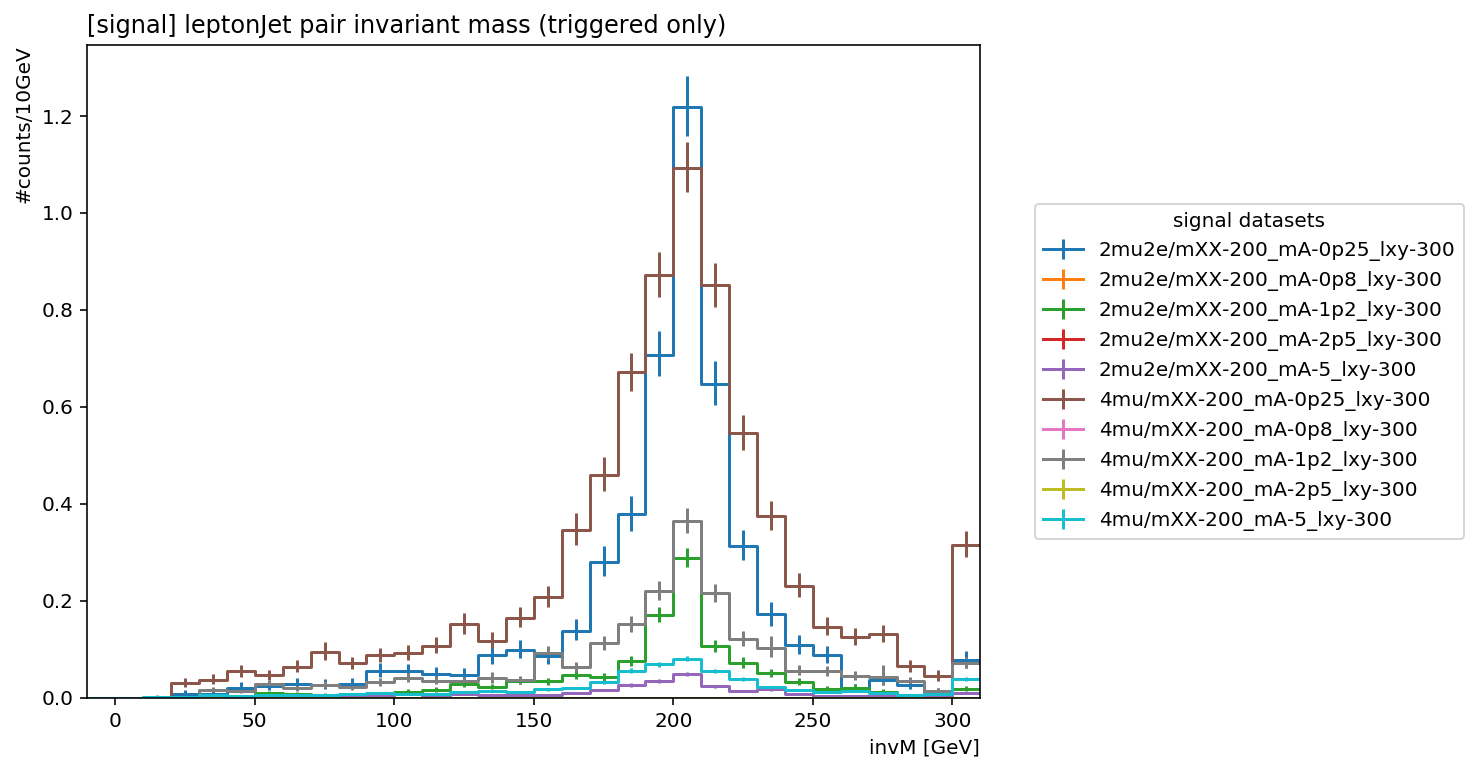

In [13]:
select = re.compile('(\w+/mXX-200_mA-\w+_lxy-\w+)')

fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['masslow'][select], overlay='dataset', ax=ax, density=False, overflow='all')
ax.set_title('[signal] leptonJet pair invariant mass (triggered only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.get_legend().set_bbox_to_anchor((1.05, 0.5));

mXX=500

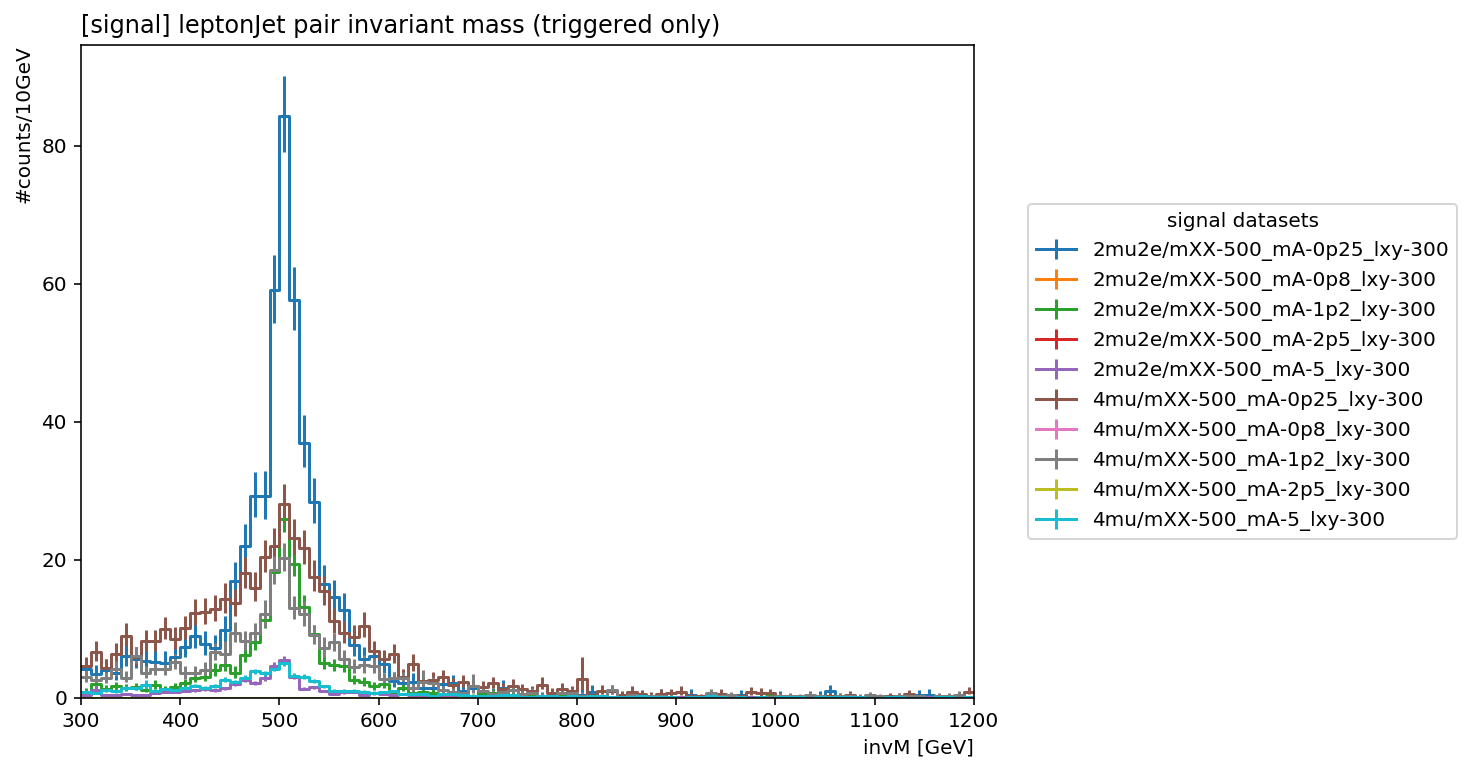

In [9]:
select = re.compile('(\w+/mXX-500_mA-\w+_lxy-\w+)')

fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['masshigh'][select], overlay='dataset', ax=ax, density=False)
ax.set_title('[signal] leptonJet pair invariant mass (triggered only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.get_legend().set_bbox_to_anchor((1.05, 0.5));

mXX=800

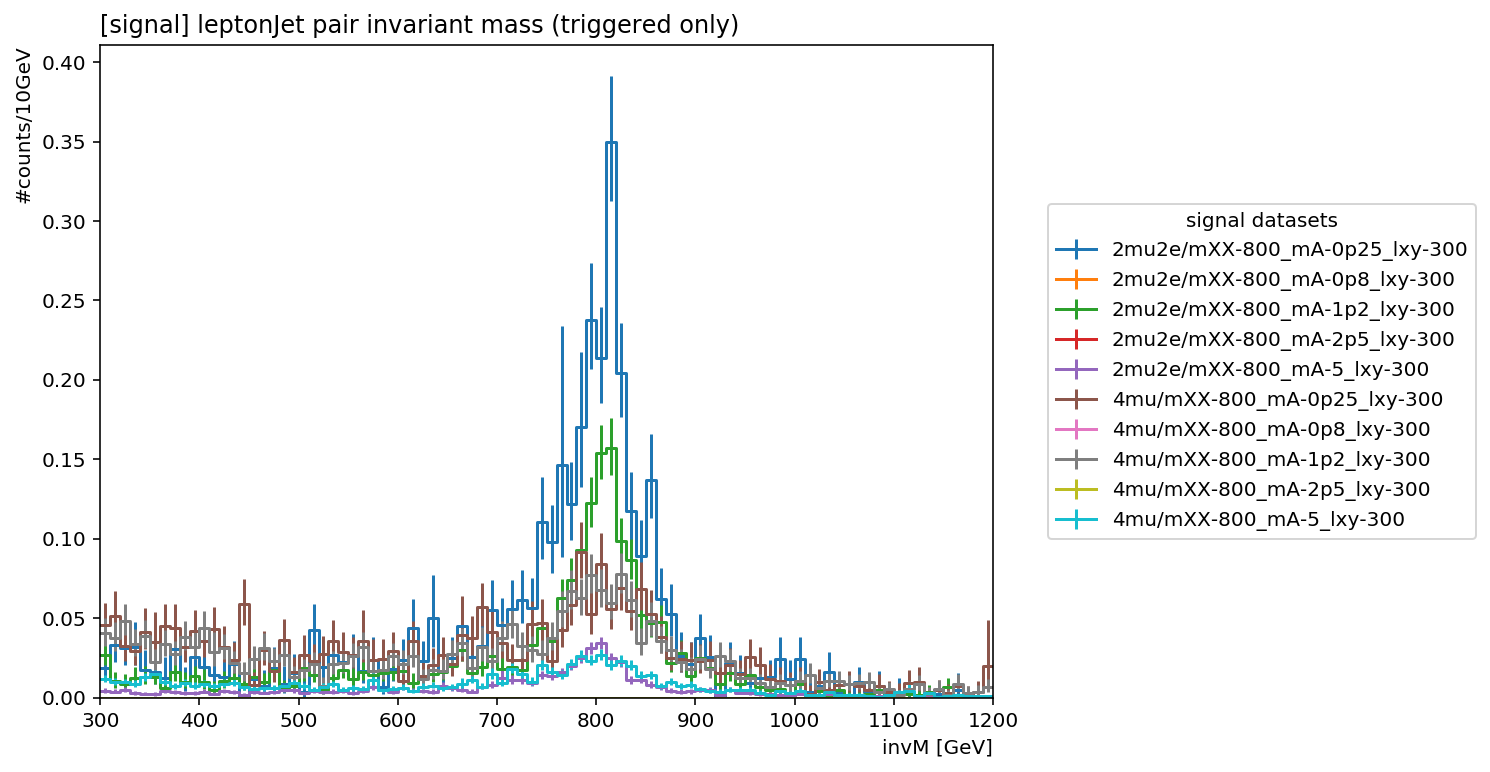

In [10]:
select = re.compile('(\w+/mXX-800_mA-\w+_lxy-\w+)')

fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['masshigh'][select], overlay='dataset', ax=ax, density=False)
ax.set_title('[signal] leptonJet pair invariant mass (triggered only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.get_legend().set_bbox_to_anchor((1.05, 0.5));

mXX=1000

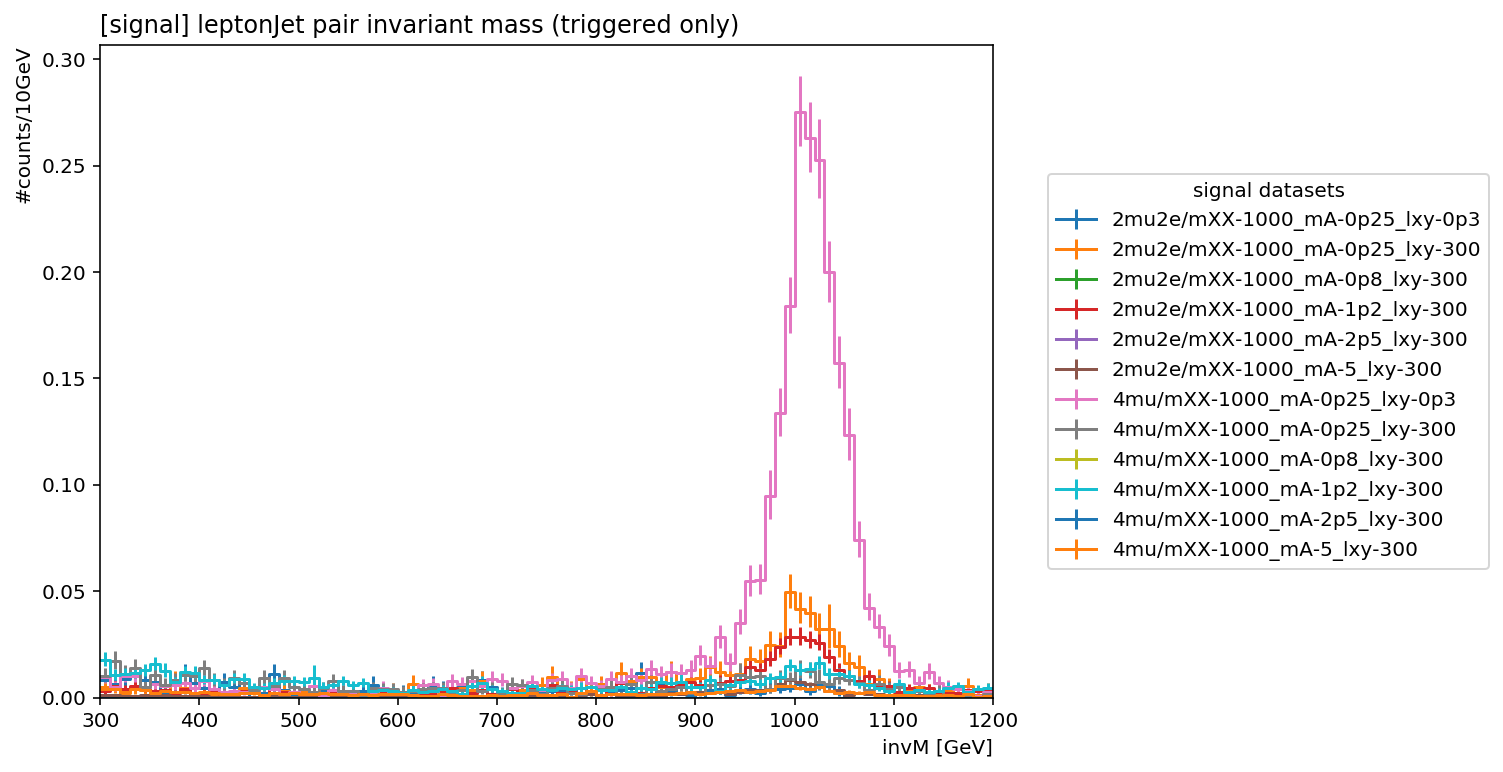

In [11]:
select = re.compile('(\w+/mXX-1000_mA-\w+_lxy-\w+)')

fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['masshigh'][select], overlay='dataset', ax=ax, density=False)
ax.set_title('[signal] leptonJet pair invariant mass (triggered only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.get_legend().set_bbox_to_anchor((1.05, 0.5));

only those matched with gen dark photons!

In [58]:
class LeptonJetPairProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'signal')
        mass_axis = hist.Bin("mass", "invM [GeV]", 50, 0, 300)
        masss_axis = hist.Bin("mass", "invM [GeV]", 50, 0, 1200)
        dphi_axis = hist.Bin('dphi', "$\Delta\Phi$", 50, 0, 3.142)
        
        self._accumulator = processor.dict_accumulator({
            'mass': hist.Hist("A.U./10GeV", dataset_axis, mass_axis),
            'masss': hist.Hist("A.U./10GeV", dataset_axis, masss_axis),
            'dphi': hist.Hist("A.U./$\pi$/50", dataset_axis, dphi_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid']
        )
        darkphotons = genparticles[genparticles.pid==32]
        matchmask = leptonjets.match(darkphotons, deltaRCut=0.3)
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        leptonjets = leptonjets[matchmask][metfiltermask&triggermask]
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size!=0:
            leadingLjPair = leptonjetpair[sumpt.argmax()]
            dphi = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))
            
            output['mass'].fill(dataset=dataset, mass=leadingLjPair.mass.flatten())
            output['masss'].fill(dataset=dataset, mass=leadingLjPair.mass.flatten())
            output['dphi'].fill(dataset=dataset, dphi=dphi.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [59]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetPairProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing:   0%|          | 0/300 [00:00<?, ?items/s]/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7

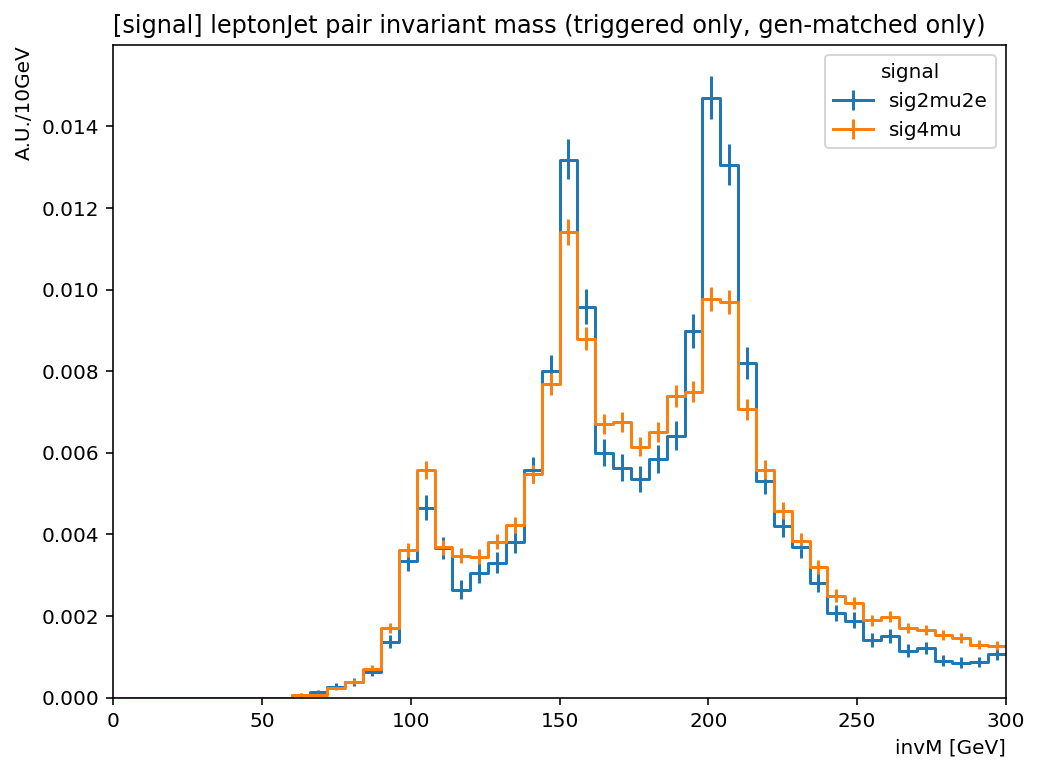

In [60]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['mass'], overlay='dataset', ax=ax, density=True)
ax.set_title('[signal] leptonJet pair invariant mass (triggered only, gen-matched only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

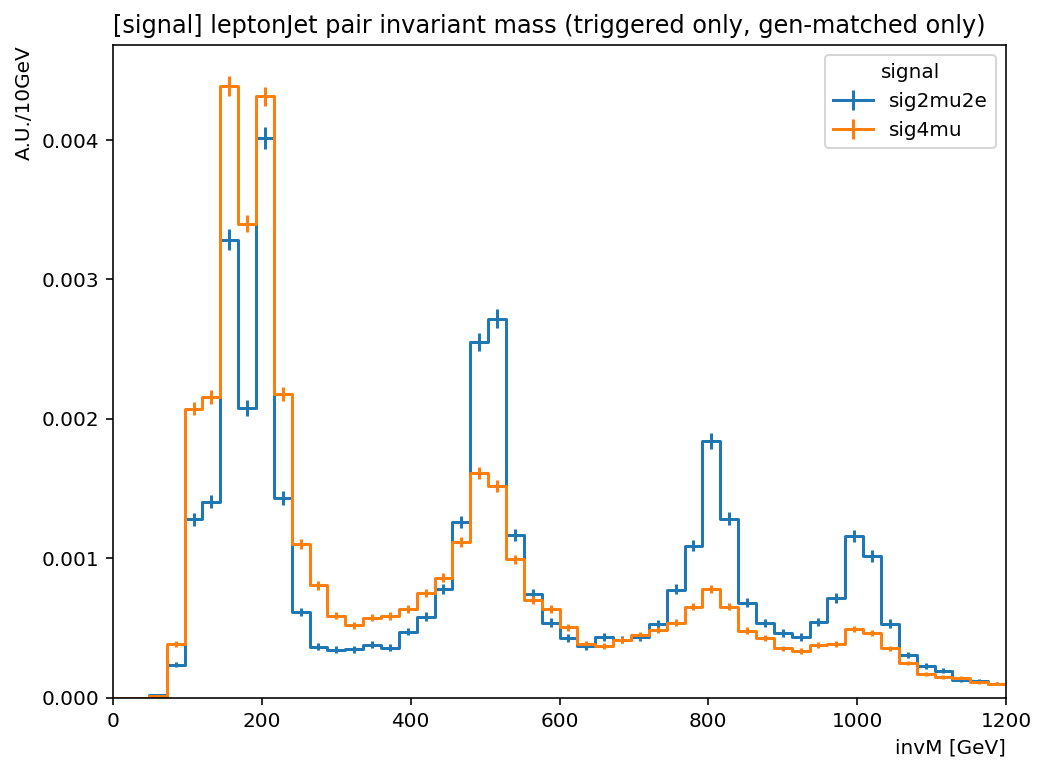

In [61]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['masss'], overlay='dataset', ax=ax, density=True)
ax.set_title('[signal] leptonJet pair invariant mass (triggered only, gen-matched only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

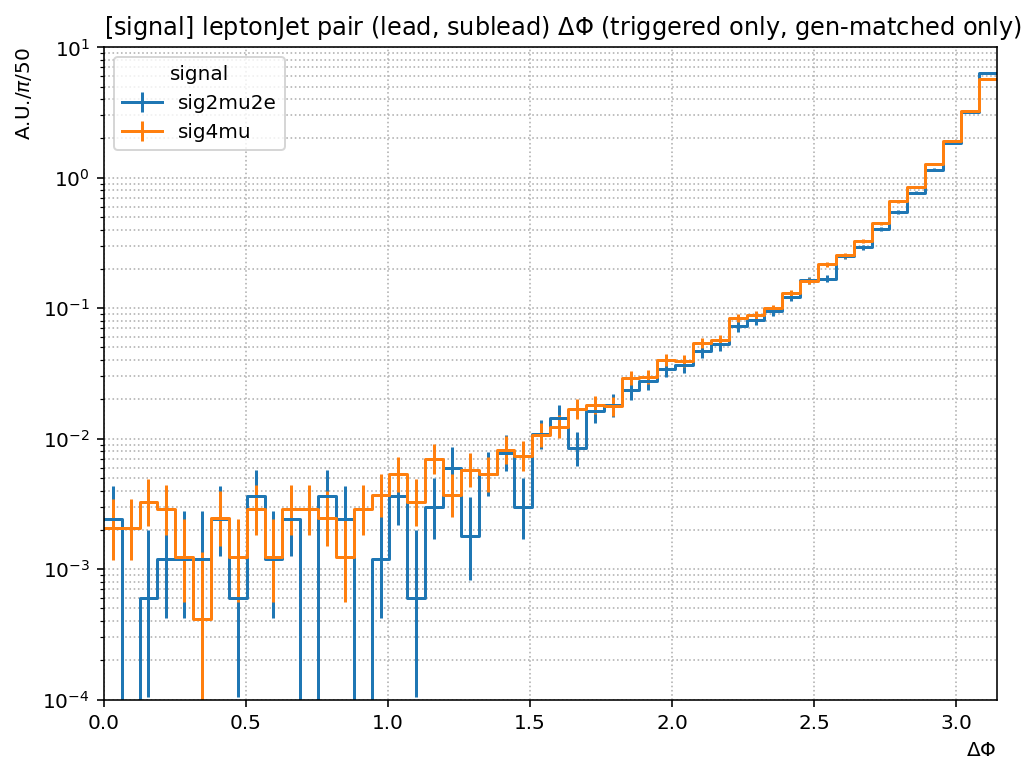

In [63]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['dphi'], overlay='dataset', ax=ax, density=True)
ax.set_title('[signal] leptonJet pair (lead, sublead) $\Delta\Phi$ (triggered only, gen-matched only)', x=0.0, ha="left")
ax.set_yscale('log')
ax.grid(which='both', ls=':')
ax.set_ylim([1e-4, 1e1])
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

### leading and subleading leptonJets kinematics
- pT, eta

In [64]:
class LeptonJetPairProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'signal')
        pt_axis      = hist.Bin("pt", "pT [GeV]", 50, 0, 800)
        eta_axis     = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        order_axis   = hist.Cat('order', 'pT order')
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("A.U./16GeV", dataset_axis, pt_axis, order_axis),
            'eta': hist.Hist("A.U./0.096", dataset_axis, eta_axis, order_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        leptonjets = leptonjets[metfiltermask&triggermask]
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size!=0:
            leadingLjPair = leptonjetpair[sumpt.argmax()]
            _comp = leadingLjPair.i0.pt<leadingLjPair.i1.pt
            leadlj = leadingLjPair.i0*(~_comp)+leadingLjPair.i1*(_comp)
            subllj = leadingLjPair.i0*(_comp)+leadingLjPair.i1*(~_comp)
            
            output['pt'].fill(dataset=dataset, pt=leadlj.p4.pt.flatten(), order='leading')
            output['eta'].fill(dataset=dataset, eta=leadlj.p4.eta.flatten(), order='leading')
            output['pt'].fill(dataset=dataset, pt=subllj.p4.pt.flatten(), order='subleading')
            output['eta'].fill(dataset=dataset, eta=subllj.p4.eta.flatten(), order='subleading')
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [65]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetPairProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 300/300 [00:15<00:00, 19.82items/s]


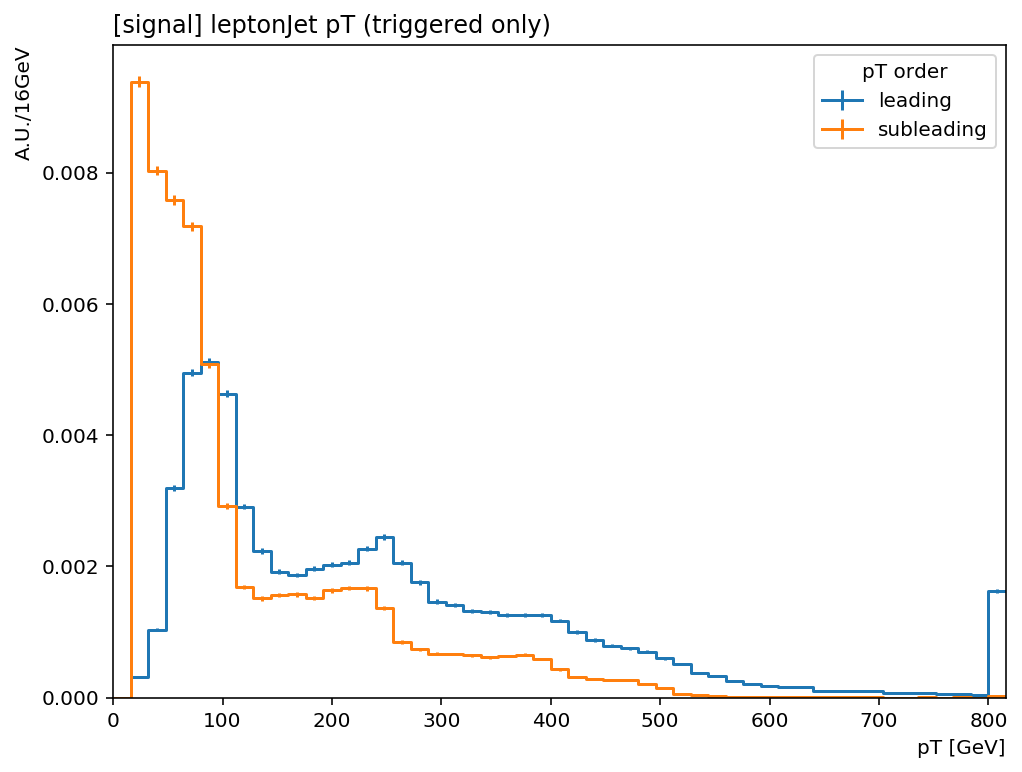

In [67]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['pt'].project('dataset'), overlay='order', ax=ax, density=True, overflow='over')
ax.set_title('[signal] leptonJet pT (triggered only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

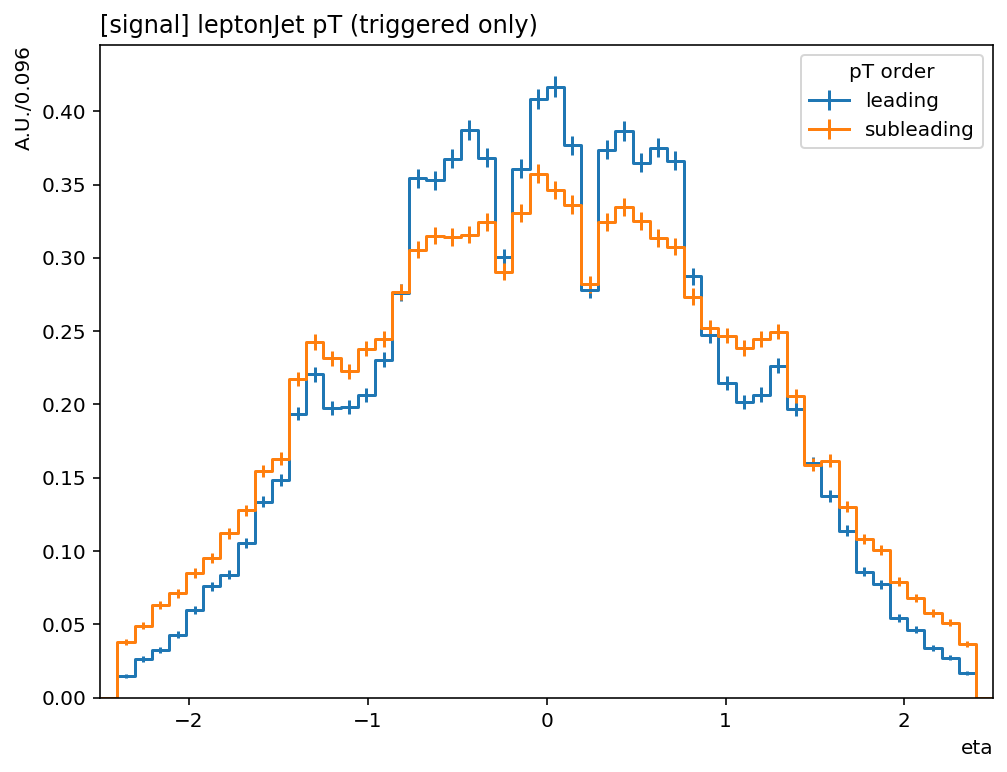

In [68]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['eta'].project('dataset'), overlay='order', ax=ax, density=True, overflow='all')
ax.set_title('[signal] leptonJet pT (triggered only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

### Fractions of leading and subleading leptonJets matched with gen dark photons

In [69]:
class LeptonJetPairProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'signal')
        match_axis   = hist.Bin('match', 'match', 2, 0, 2)
        order_axis   = hist.Cat('order', 'pT order')
        
        self._accumulator = processor.dict_accumulator({
            'matched': hist.Hist('#counts', dataset_axis, match_axis, order_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid']
        )
        darkphotons = genparticles[genparticles.pid==32]
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        leptonjets = leptonjets[metfiltermask&triggermask]
        darkphotons = darkphotons[metfiltermask&triggermask]
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        darkphotons = darkphotons[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size!=0:
            leadingLjPair = leptonjetpair[sumpt.argmax()]
            _comp = leadingLjPair.i0.pt<leadingLjPair.i1.pt
            leadlj_ = leadingLjPair.i0*(~_comp)+leadingLjPair.i1*(_comp)
            subllj_ = leadingLjPair.i0*(_comp)+leadingLjPair.i1*(~_comp)
            leadlj = JaggedCandidateArray.candidatesfromcounts(leadlj_.counts,
                                                               pt=leadlj_.p4.pt.content,
                                                               eta=leadlj_.p4.eta.content,
                                                               phi=leadlj_.p4.phi.content,
                                                               energy=leadlj_.p4.energy.content)
            subllj = JaggedCandidateArray.candidatesfromcounts(subllj_.counts,
                                                               pt=subllj_.p4.pt.content,
                                                               eta=subllj_.p4.eta.content,
                                                               phi=subllj_.p4.phi.content,
                                                               energy=subllj_.p4.energy.content)

            output['matched'].fill(dataset=dataset, match=leadlj.match(darkphotons, deltaRCut=0.3).flatten(), order='leading')
            output['matched'].fill(dataset=dataset, match=subllj.match(darkphotons, deltaRCut=0.3).flatten(), order='subleading')
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [70]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetPairProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing:   0%|          | 0/300 [00:00<?, ?items/s]/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7

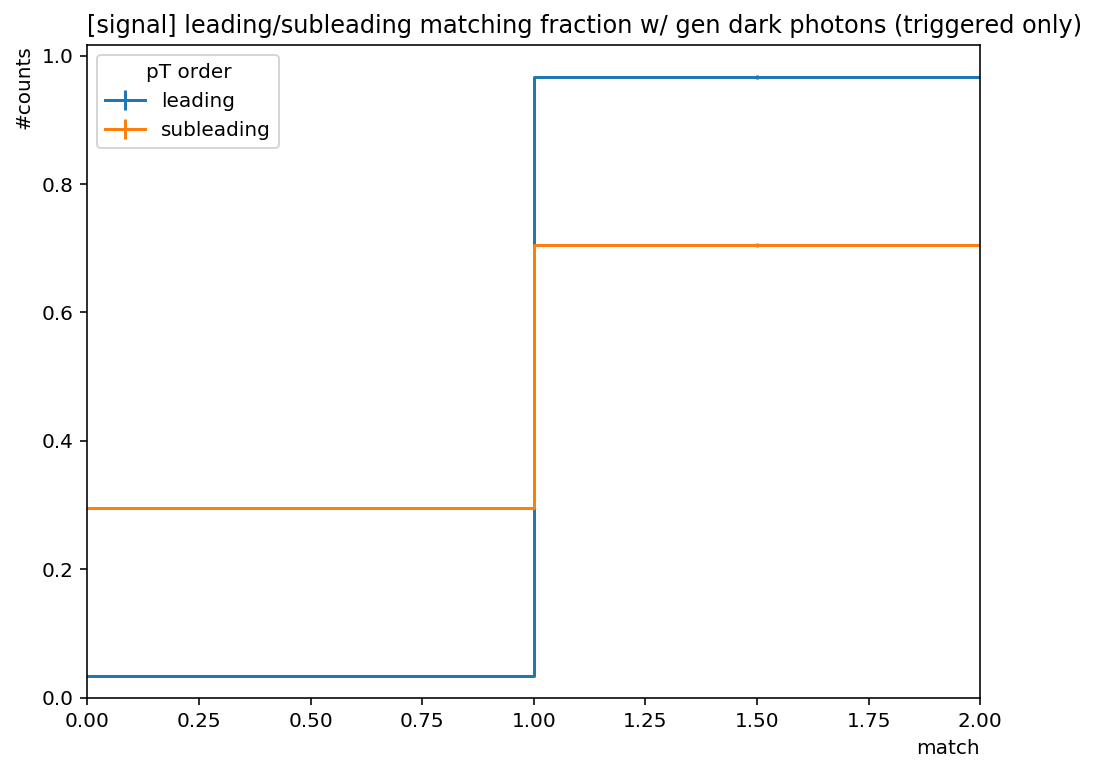

In [72]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['matched'].project('dataset'), overlay='order', ax=ax, density=True,)
ax.set_title('[signal] leading/subleading matching fraction w/ gen dark photons (triggered only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

matched(both) fraction/ >1 fraction? which one is more?

---